<a href="https://colab.research.google.com/github/AubLambert/FraudDetection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Import Libraries

In [1]:
!pip install xgboost

In [2]:
!pip install category_encoders

In [3]:
!pip install imbalanced-learn

In [4]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

# Scipy
from scipy.stats import chi2_contingency
from scipy.stats import mode
from scipy.stats import skew

# Sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay, average_precision_score, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Light GBM
import lightgbm as lgb
from lightgbm import Booster, LGBMClassifier
from lightgbm.callback import early_stopping, log_evaluation

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Joblib
import joblib

import warnings
warnings.filterwarnings("ignore")

# Step 1: Basic Analysis

## Train Set

### Import Data

In [5]:
# Setup pandas to display all columns
pd.set_option('display.max_columns', None)

# Setup column width to avoid line breaks
pd.set_option('display.width', None)

df = pd.read_csv('fraudTrain.csv', on_bad_lines='warn')
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


In [6]:
df = df.drop('Unnamed: 0', axis=1)

### Descriptive Statistics

In [7]:
# Descriptive statistics
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [8]:
# Train set dimension
df.shape

(1296675, 22)

In [9]:
# Train set basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [10]:
# Null check
df.isnull().sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


In [11]:
# Numerical unique value
df.select_dtypes(include=['int64', 'float64']).nunique()

,0
cc_num,983
amt,52928
zip,970
lat,968
long,969
city_pop,879
unix_time,1274823
merch_lat,1247805
merch_long,1275745
is_fraud,2


In [12]:
# Categorical unique value
df.select_dtypes(include=['object', 'category']).nunique()

,0
trans_date_trans_time,1274791
merchant,693
category,14
first,352
last,481
gender,2
street,983
city,894
state,51
job,494


## Test Set

### Import Data

In [13]:
df_test = pd.read_csv('fraudTest.csv', on_bad_lines='warn')
df_test

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,MO,63453,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
555715,555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,77566,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
555716,555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
555717,555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


In [14]:
df_test = df_test.drop('Unnamed: 0', axis=1)

### Descriptive Statistics

In [15]:
df_test.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,5.557190e+05,5.557190e+05,555719.000000,555719.000000,555719.000000
mean,4.178387e+17,69.392810,48842.628015,38.543253,-90.231325,8.822189e+04,1.380679e+09,38.542798,-90.231380,0.003860
std,1.309837e+18,156.745941,26855.283328,5.061336,13.721780,3.003909e+05,5.201104e+06,5.095829,13.733071,0.062008
min,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.371817e+09,19.027422,-166.671575,0.000000
25%,1.800429e+14,9.630000,26292.000000,34.668900,-96.798000,7.410000e+02,1.376029e+09,34.755302,-96.905129,0.000000
50%,3.521417e+15,47.290000,48174.000000,39.371600,-87.476900,2.408000e+03,1.380762e+09,39.376593,-87.445204,0.000000
75%,4.635331e+15,83.010000,72011.000000,41.894800,-80.175200,1.968500e+04,1.385867e+09,41.954163,-80.264637,0.000000
max,4.992346e+18,22768.110000,99921.000000,65.689900,-67.950300,2.906700e+06,1.388534e+09,66.679297,-66.952026,1.000000


In [16]:
df_test.shape

(555719, 22)

In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-nu

In [18]:
df_test.isnull().sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


In [19]:
df_test.select_dtypes(include=['int64', 'float64']).nunique()

,0
cc_num,924
amt,37256
zip,912
lat,910
long,910
city_pop,835
unix_time,544760
merch_lat,546490
merch_long,551770
is_fraud,2


In [20]:
df_test.select_dtypes(include=['object', 'category']).nunique()

,0
trans_date_trans_time,544760
merchant,693
category,14
first,341
last,471
gender,2
street,924
city,849
state,50
job,478


# Step 2: EDA

In [21]:
# Create a copy for EDA
df_viz = df.copy()
# All visualization and transformation in EDA use df_viz

## Data Transformation for Vizualization

### Fraud Rate

In [22]:
fraud_percent = (df['is_fraud'] == 1).sum()/(df.shape[0])

print(f"Fraud Percentage: {fraud_percent * 100:.5f}%")

Fraud Percentage: 0.57887%


### Correlation

#### Reorder df

In [23]:
target_col = "is_fraud"

# Move target to the end of df
def reorder(df):
    cols = [c for c in df.columns if c != target_col] + [target_col]
    df = df[cols]
    return df

df_viz = reorder(df_viz)

#### Numerical correlation

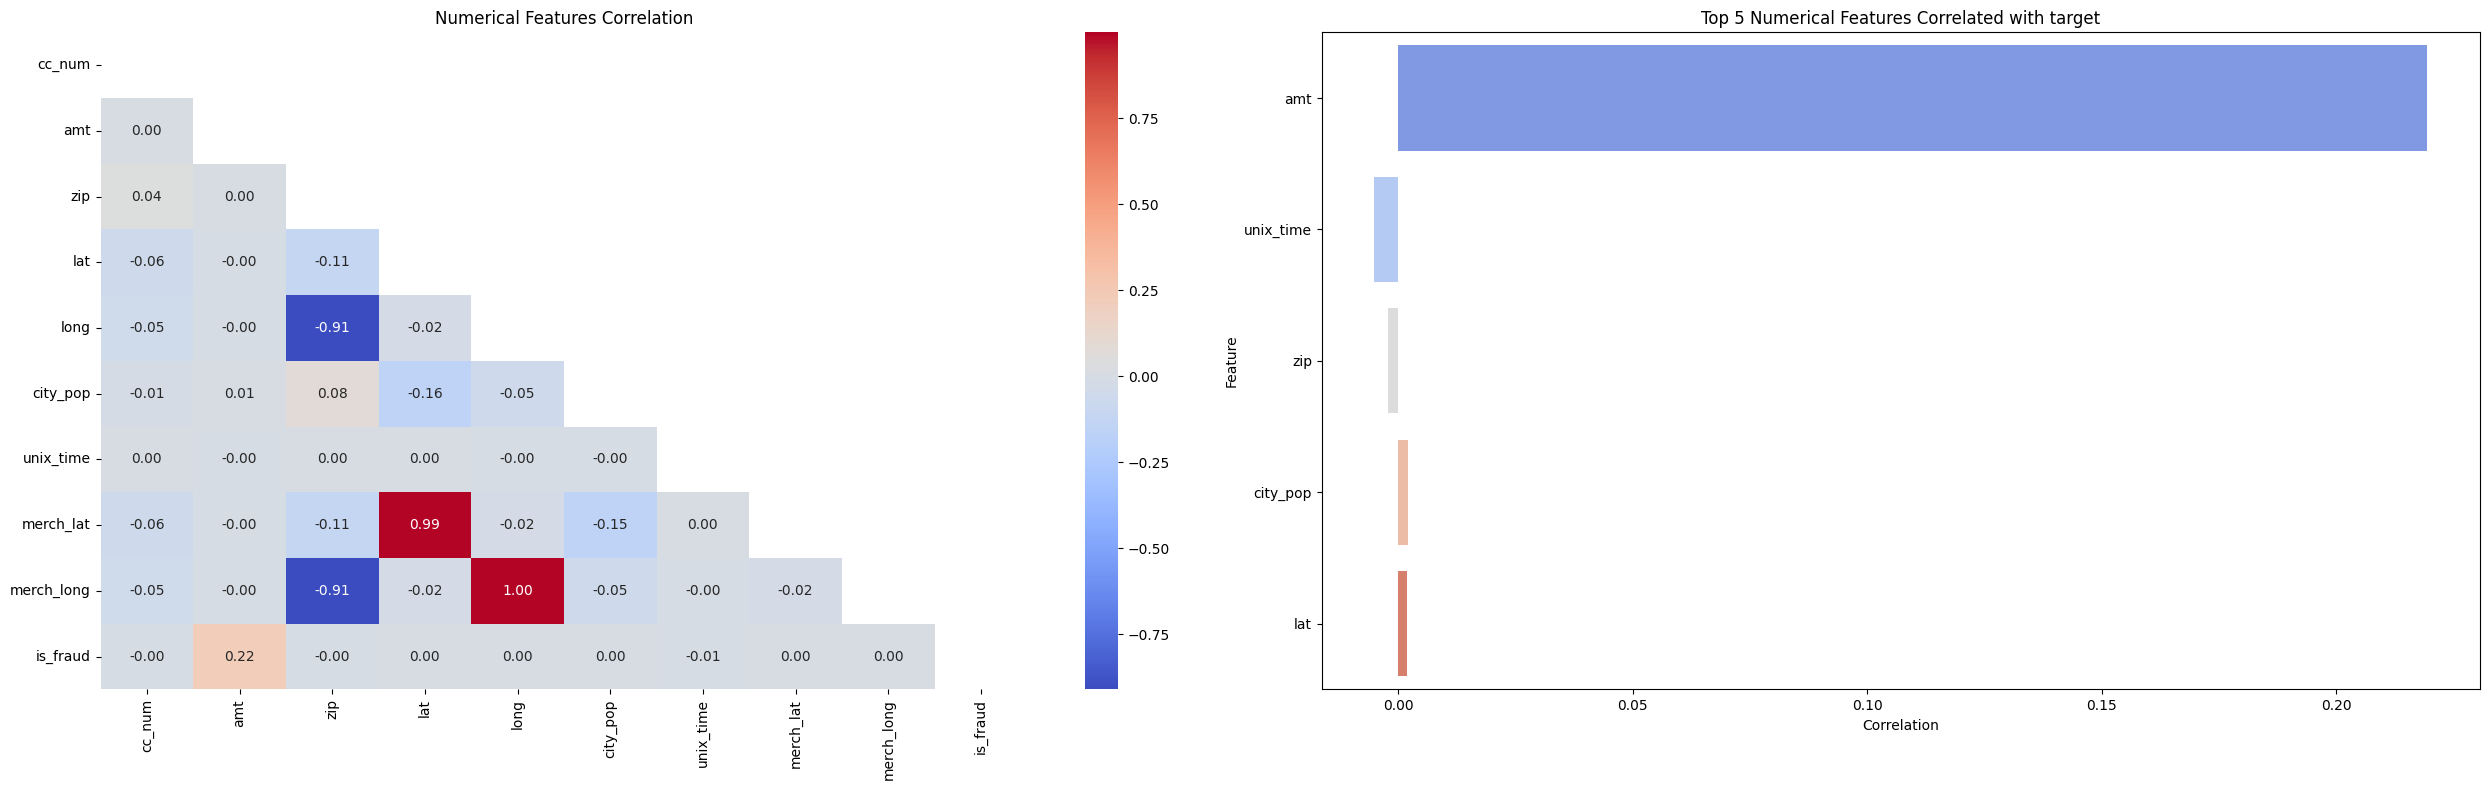

In [24]:
def num_corr(df, target="is_fraud", n=5):
    # Select numerical features
    num_cols = df.select_dtypes(include=['int32', 'int64', 'float64'])

    # Pearson correlation matrix
    corr_num = num_cols.corr()

    # Correlations with target
    corr_target = corr_num[target].drop(target)

    # Get top n (absolute) correlations
    top_features = corr_target.abs().sort_values(ascending=False).head(n)
    top_features_signed = corr_target.loc[top_features.index]

    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 8))

    # Correlation heatmap
    mask = np.triu(np.ones_like(corr_num, dtype=bool))
    sns.heatmap(corr_num, mask=mask, cmap="coolwarm", annot=True, fmt=".2f",
                cbar=True, ax=ax1)
    ax1.set_title("Numerical Features Correlation")

    # Top N correlations
    sns.barplot(x=top_features_signed.values, y=top_features_signed.index,
                palette="coolwarm", ax=ax2)
    ax2.set_title(f"Top {n} Numerical Features Correlated with target")
    ax2.set_xlabel("Correlation")
    ax2.set_ylabel("Feature")

    plt.tight_layout()
    plt.show()

num_corr(df_viz)

#### Categorical correlation

In [25]:
# New df for correlation matrix, dropping unnecessary columns
df_viz_samp = df_viz.drop(["trans_date_trans_time", "dob", "trans_num"], axis=1)

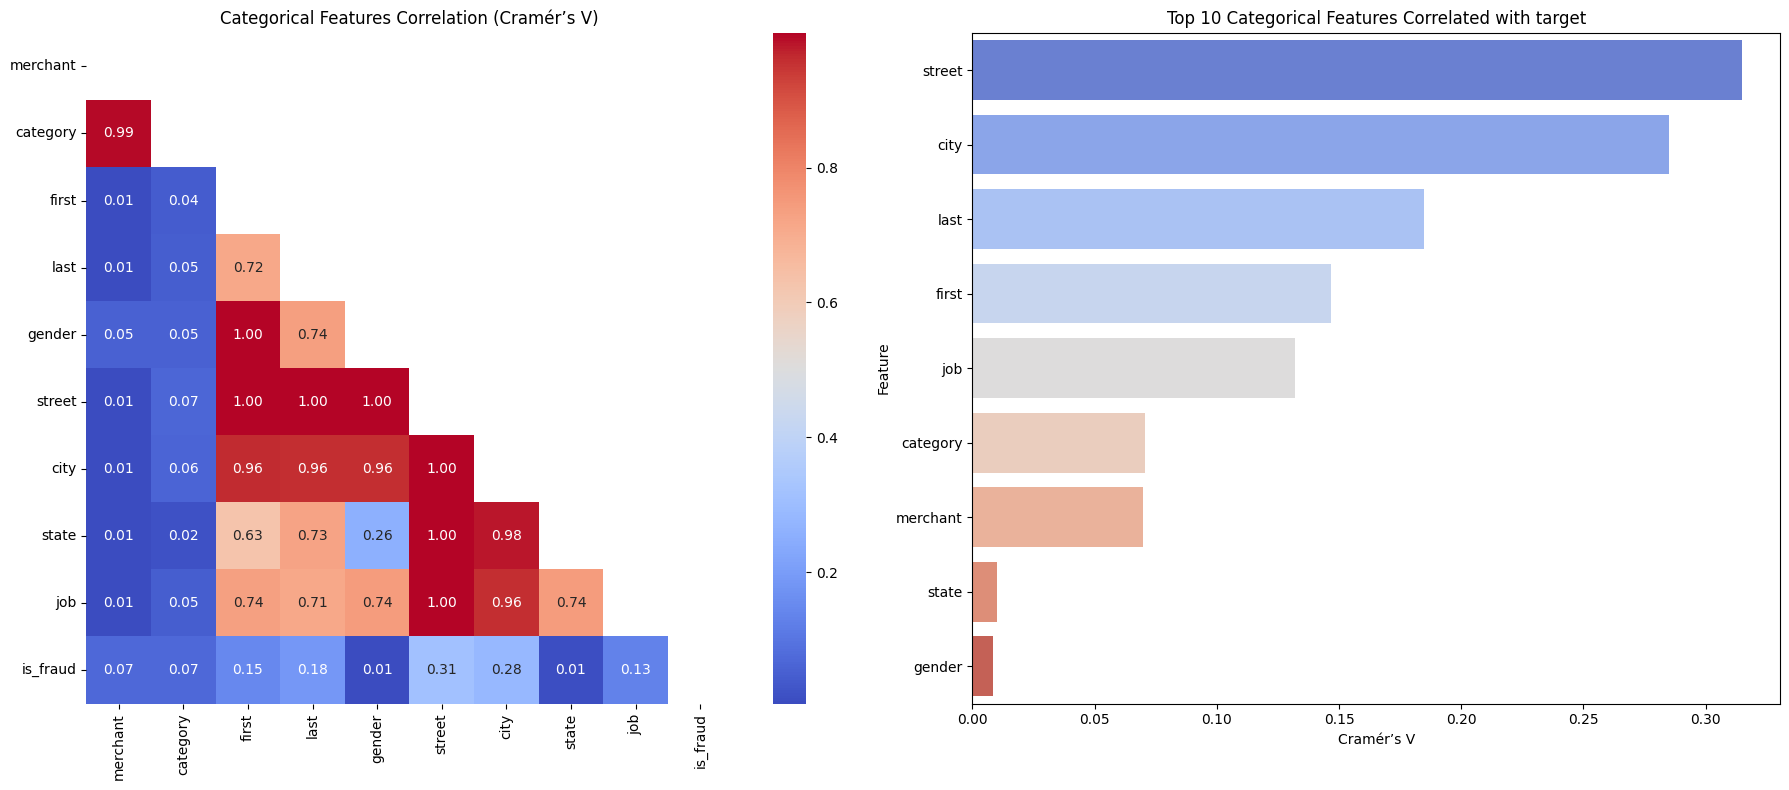

In [26]:
def cat_corr(df, n=10):
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n_obs = confusion_matrix.sum().sum()
        phi2 = chi2 / n_obs
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n_obs-1))
        rcorr = r - ((r-1)**2) / (n_obs-1)
        kcorr = k - ((k-1)**2) / (n_obs-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

    # Sample to reduce computation cost
    df_viz_samp = df.sample(frac=0.1, random_state=42)
    df_viz_samp["is_fraud"] = df_viz_samp["is_fraud"].astype("category")
    cat_cols = df_viz_samp.select_dtypes(include=["object", "category"]).astype("category")

    # Compute Cramér’s V with target
    corr_with_target = {}
    for c in cat_cols.columns:
        if c != "is_fraud":
            corr_with_target[c] = cramers_v(cat_cols[c], df_viz_samp["is_fraud"])

    # Sort by strength
    sorted_corr = pd.Series(corr_with_target).sort_values(ascending=False)

    # Compute Cramér’s V matrix
    corr_cat = pd.DataFrame(np.zeros((len(cat_cols.columns), len(cat_cols.columns))),
                            index=cat_cols.columns, columns=cat_cols.columns)
    for c1 in cat_cols.columns:
        for c2 in cat_cols.columns:
            corr_cat.loc[c1, c2] = cramers_v(cat_cols[c1], cat_cols[c2])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Correlation heatmap
    mask = np.triu(np.ones_like(corr_cat, dtype=bool))
    sns.heatmap(corr_cat, mask=mask, cmap="coolwarm", annot=True, fmt=".2f",
                cbar=True, ax=ax1)
    ax1.set_title("Categorical Features Correlation (Cramér’s V)")

    # Top N correlations
    sns.barplot(x=sorted_corr.head(n).values,
                y=sorted_corr.head(n).index,
                palette="coolwarm",
                ax=ax2)
    ax2.set_title(f"Top {n} Categorical Features Correlated with target")
    ax2.set_xlabel("Cramér’s V")
    ax2.set_ylabel("Feature")

    plt.tight_layout()
    plt.show()

cat_corr(df_viz_samp)

In [27]:
df_viz = df_viz.copy()

### Date and Time Heatmap


#### Transaction

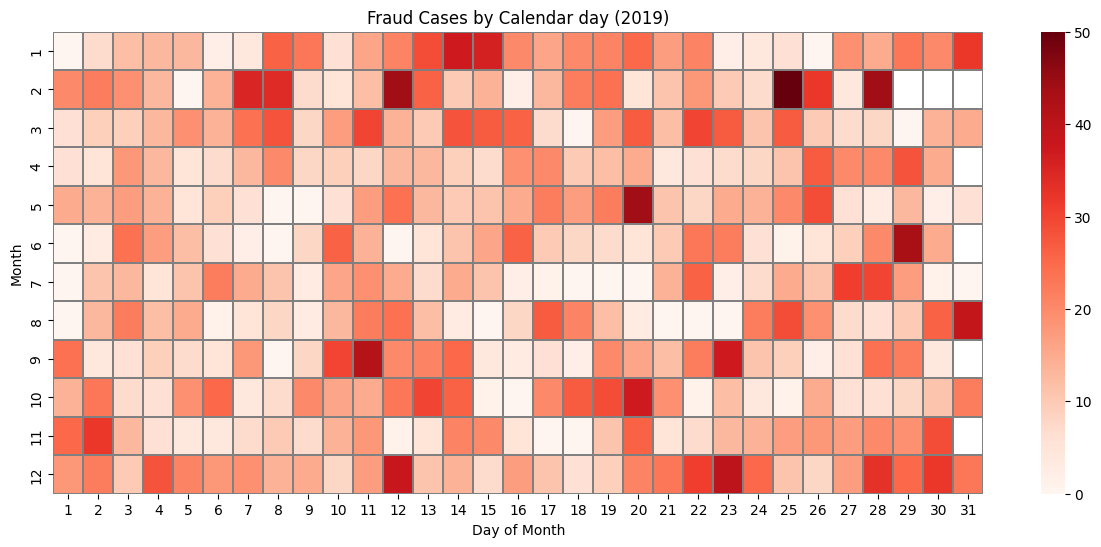

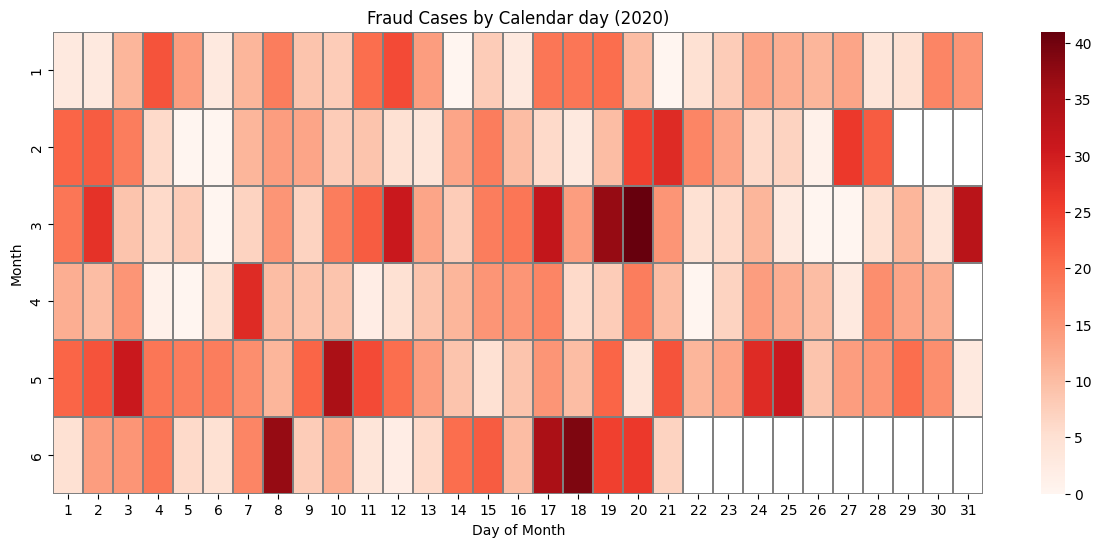

In [28]:
# Transform transaction date&time feature
df_viz["trans_date_trans_time"] = pd.to_datetime(df_viz["trans_date_trans_time"])
df_viz["year"] = df_viz["trans_date_trans_time"].dt.year
df_viz["month"] = df_viz["trans_date_trans_time"].dt.month
df_viz["day"] = df_viz["trans_date_trans_time"].dt.day
df_viz["hour"] = df_viz["trans_date_trans_time"].dt.hour
df_viz["minute"] = df_viz["trans_date_trans_time"].dt.minute
df_viz["second"] = df_viz["trans_date_trans_time"].dt.second

# Calendar heatmap (Day x Month x Year)
fraud_calendar = df_viz.groupby(["year","month","day"])["is_fraud"].sum().reset_index()

for yr in sorted(fraud_calendar["year"].unique()):
    pivoted = fraud_calendar[fraud_calendar["year"]==yr].pivot(
        index="month", columns="day", values="is_fraud"
    )

    plt.figure(figsize=(15,6))
    sns.heatmap(pivoted, cmap="Reds", cbar=True, linewidths=0.1, linecolor="grey")
    plt.title(f"Fraud Cases by Calendar day ({yr})")
    plt.xlabel("Day of Month")
    plt.ylabel("Month")
    plt.show()

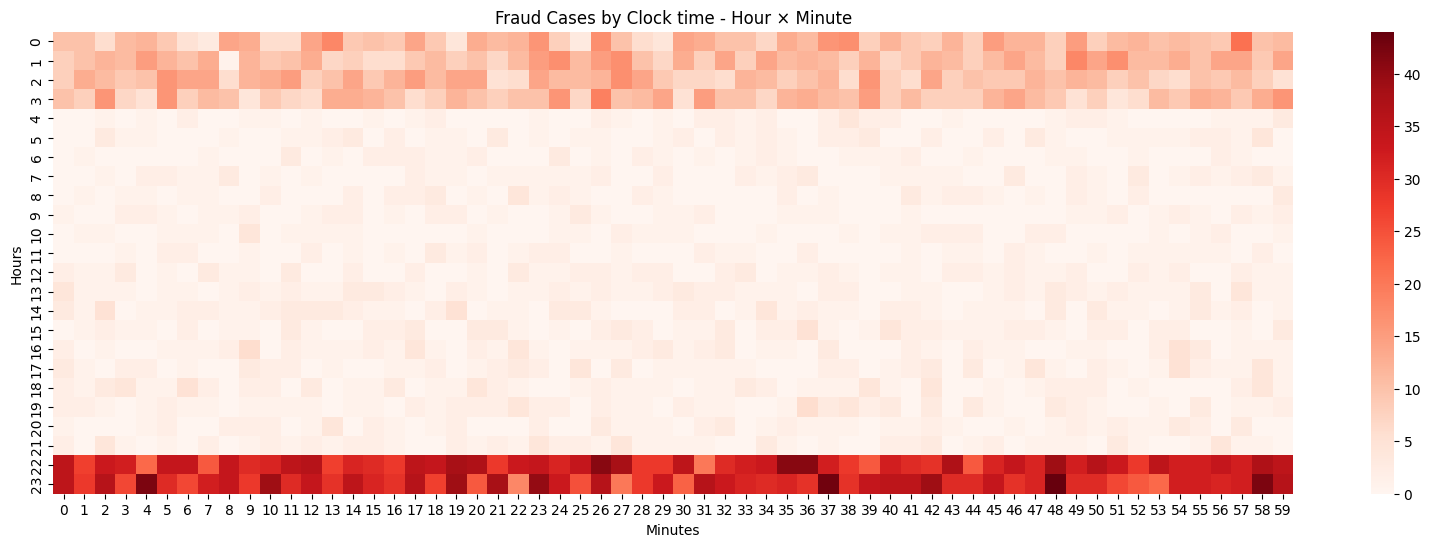

In [29]:
# Clock heatmap (Minute x Hour)
fraud_clock_min = df_viz.groupby(["hour","minute"])["is_fraud"].sum().reset_index()

pivoted_clock_min = fraud_clock_min.pivot_table(
    index="hour", columns="minute", values="is_fraud", fill_value=0
)

plt.figure(figsize=(20,6))
sns.heatmap(pivoted_clock_min, cmap="Reds", cbar=True)
plt.title("Fraud Cases by Clock time - Hour × Minute")
plt.xlabel("Minutes")
plt.ylabel("Hours")
plt.show()

#### DoB

In [30]:
# Transform DoB feature
df_viz["dob"] = pd.to_datetime(df_viz["dob"])
df_viz["dob_year"] = df_viz["dob"].dt.year
df_viz["dob_month"] = df_viz["dob"].dt.month
df_viz["dob_day"] = df_viz["dob"].dt.day

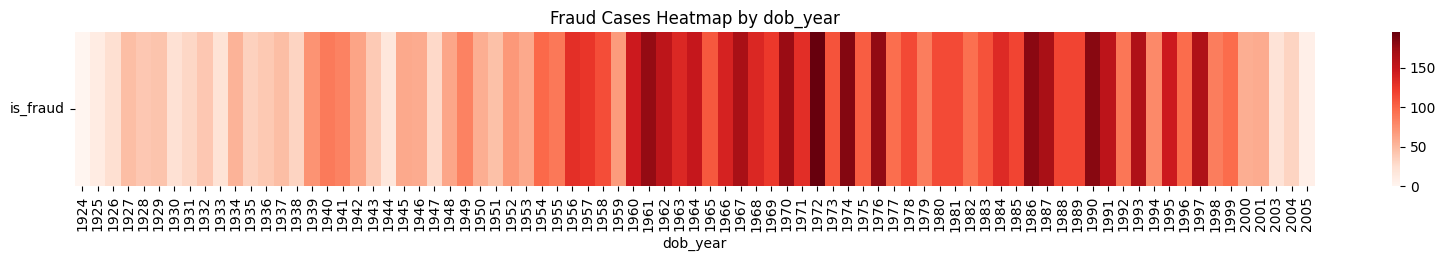

In [31]:
# Fraud case by birth year
def feature_to_target(df, column):
    partition = df.groupby(column)["is_fraud"].sum().reset_index()

    # Flatten into 1-row
    heatmap_data = partition.set_index(column).T

    plt.figure(figsize=(20, 2))
    sns.heatmap(
        heatmap_data,
        cmap="Reds",
        annot=False,
        cbar=True
    )
    plt.title(f"Fraud Cases Heatmap by {column}")
    plt.yticks(rotation=0)
    plt.show()

feature_to_target(df_viz, "dob_year")

### Concatenate customer_name

In [32]:
# Concatenate customer name
df_viz["customer_name"] = df_viz["first"].str.cat(df_viz["last"], sep=' ')

# Customer count
df_viz["customer_name"].nunique()

# Drop redundant features
df_viz = df_viz.drop(["first", "last"], axis=1)

### Split street components

In [33]:
splits = df_viz["street"].str.split(" ", expand=True)

# Split into 5 columns, corresponding to 5 components
df_viz["str_number"]    = splits[0]
df_viz["str_name"]      = splits[1]
df_viz["str_type"]      = splits[2]
df_viz["building_type"] = splits[3]
df_viz["room_number"]   = splits[4]

df_viz = df_viz.drop('street', axis=1)

In [34]:
address = df_viz.iloc[:, 29:34]
address.nunique()

,0
str_number,930
str_name,552
str_type,193
building_type,2
room_number,385


In [35]:
address.isnull().sum()

,0
str_number,0
str_name,0
str_type,0
building_type,663417
room_number,663417


In [36]:
df_viz["building_type"] = df_viz["building_type"].replace({None: "House"})

### Split zip prefix

In [37]:
df_viz["zip"] = df_viz["zip"].astype(str).str.zfill(5)

# Extract first ZIP prefixes (first 3 digits)
df_viz["zip_prefix"] = df_viz["zip"].str[:3]

In [38]:
df_viz["zip_prefix"].nunique()

526

In [39]:
# Change dtype
df_viz["zip_prefix"] = df_viz["zip_prefix"].astype(int)
df_viz = df_viz.drop("zip", axis=1)

### Calculate distance (km) between merchants and customers

In [40]:
# Calculate Harversine distance from lat and lon
def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Haversine distance
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return r * c

df_viz['distance_km'] = haversine_vectorized(
    df_viz['lat'],
    df_viz['long'],
    df_viz['merch_lat'],
    df_viz['merch_long']
)

df_viz = df_viz.drop(["lat", "long", "merch_lat", "merch_long"], axis=1)

### Calculating age

In [41]:
df_viz["age"] = df_viz["year"] - df_viz["dob_year"]

### Correlation after transformation

In [42]:
df_viz_samp_2 = df_viz.drop(["trans_date_trans_time", "dob", "trans_num"], axis=1)

In [43]:
df_viz_samp_2 = reorder(df_viz_samp_2)

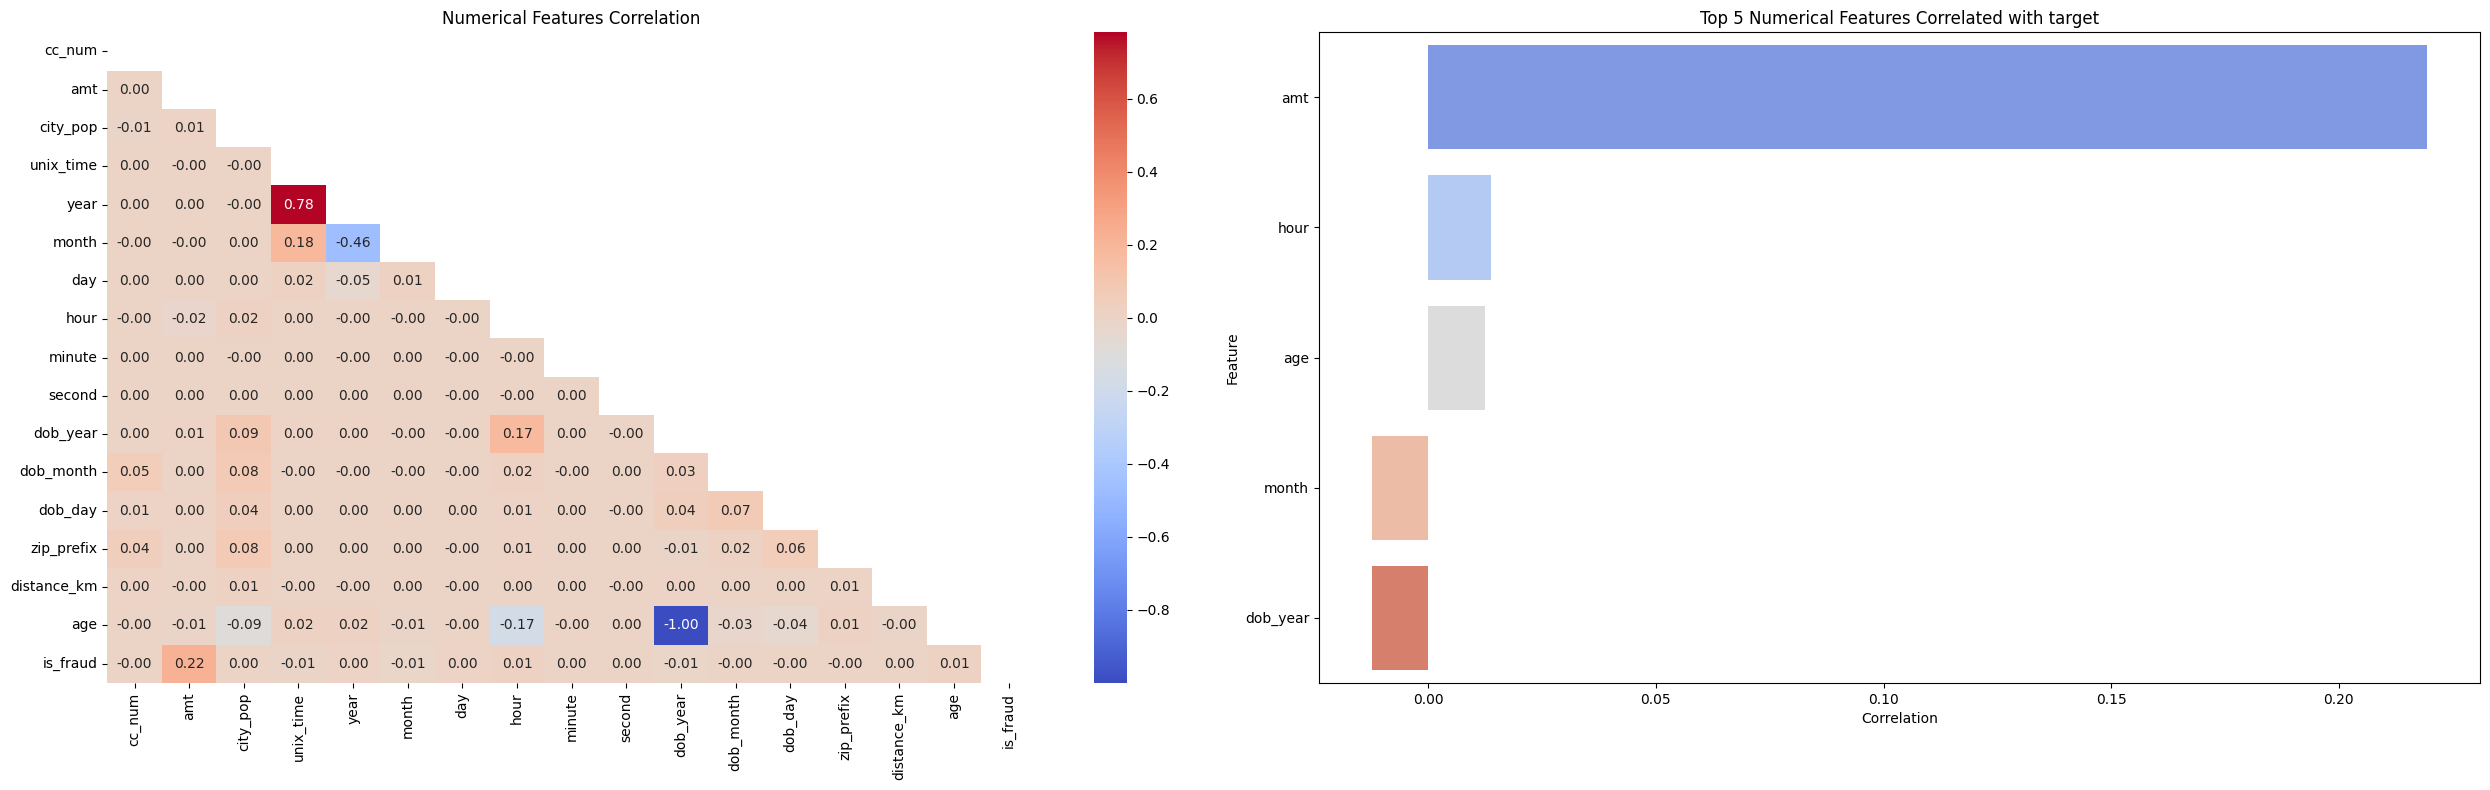

In [44]:
num_corr(df_viz_samp_2)

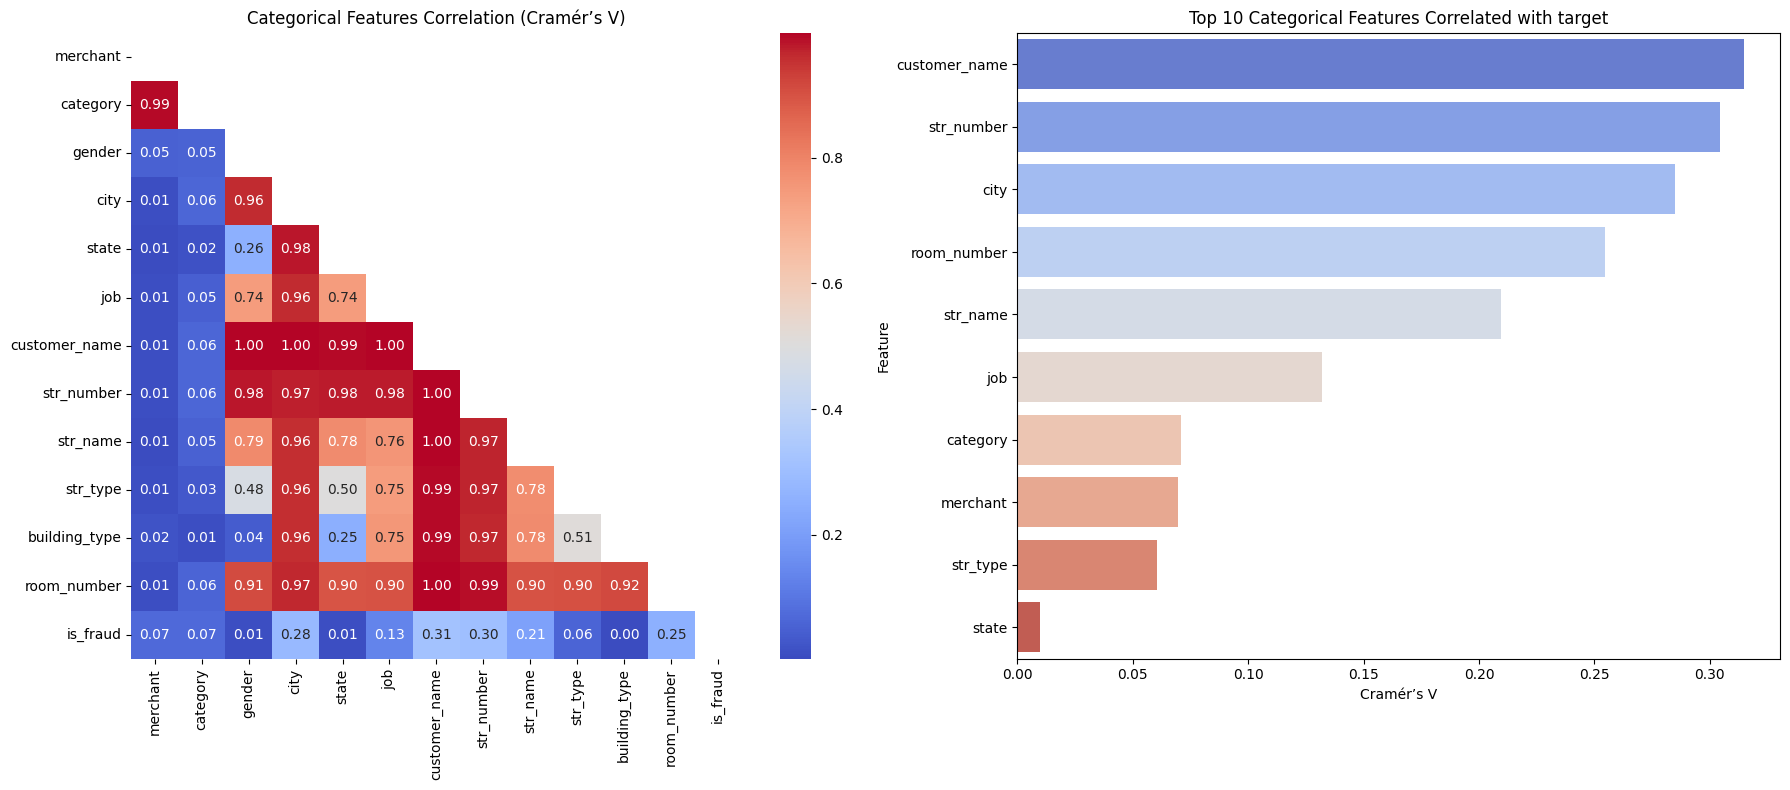

In [45]:
cat_corr(df_viz_samp_2)

In [46]:
df_viz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 32 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  int64         
 2   merchant               1296675 non-null  object        
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   gender                 1296675 non-null  object        
 6   city                   1296675 non-null  object        
 7   state                  1296675 non-null  object        
 8   city_pop               1296675 non-null  int64         
 9   job                    1296675 non-null  object        
 10  dob                    1296675 non-null  datetime64[ns]
 11  trans_num              1296675 non-null  object        
 12  unix_time              12966

## Relationship Analysis

### Fraud Rate by Category Spending

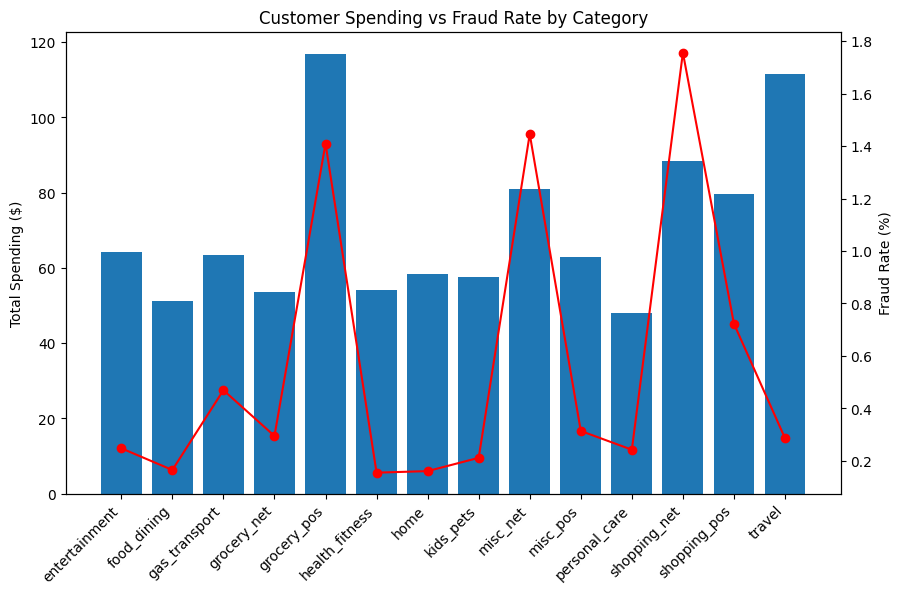

In [47]:
fraud_by_cat_amt = (
    df_viz.groupby("category")
    .agg(
        total_spent=("amt", "mean"),
        fraud_cases=("is_fraud", "sum"),
        total_transactions=("is_fraud", "count")
    )
    .reset_index()
)

fraud_by_cat_amt["fraud_rate"] = (
    fraud_by_cat_amt["fraud_cases"] * 100 / fraud_by_cat_amt["total_transactions"]
)

fig, ax1 = plt.subplots(figsize=(10,6))

# Bar chart
ax1.bar(fraud_by_cat_amt["category"], fraud_by_cat_amt["total_spent"])
ax1.set_ylabel("Total Spending ($)")
ax1.set_xticklabels(fraud_by_cat_amt["category"], rotation=45, ha="right")

# Line chart
ax2 = ax1.twinx()
ax2.plot(fraud_by_cat_amt["category"], fraud_by_cat_amt["fraud_rate"], color="red", marker="o")
ax2.set_ylabel("Fraud Rate (%)")

plt.title("Customer Spending vs Fraud Rate by Category")
plt.show()

### Fraud Cases by State

In [48]:
df_state = df_viz.groupby("state")["is_fraud"].sum().reset_index()

fig = px.choropleth(df_state,
                    locations='state',
                    locationmode='USA-states',
                    color='is_fraud',
                    scope="usa",
                    color_continuous_scale="Reds",
                    labels={'is_fraud':'Fraud Rate'}
)
fig.update_layout(title_text="Fraud Rate by State", geo_scope='usa')
fig.show()

### Total Amount of Transactions by State

In [49]:
state_amt = df_viz.groupby("state").agg(
    total_amt=("amt", "sum"),
    total_transactions=("amt", "count")
).reset_index()

fig = px.choropleth(state_amt,
                    locations='state',
                    locationmode='USA-states',
                    color='total_amt',
                    scope="usa",
                    color_continuous_scale="Reds",
                    labels={'total_amt':'Total Amount'})

fig.update_layout(title_text="Total Amount of Transactions by State", geo_scope='usa')
fig.show()

### Fraud Rate by Gender

In [50]:
# Partition by gender
fraud_rate_gender = (
    df_viz.groupby("gender")["is_fraud"]
    .agg(["sum", "count"])
    .reset_index()
)

fraud_rate_gender["fraud_rate"] = (
    fraud_rate_gender["sum"] * 100 / fraud_rate_gender["count"]
)

print(fraud_rate_gender)

  gender   sum   count  fraud_rate
0      F  3735  709863    0.526158
1      M  3771  586812    0.642625


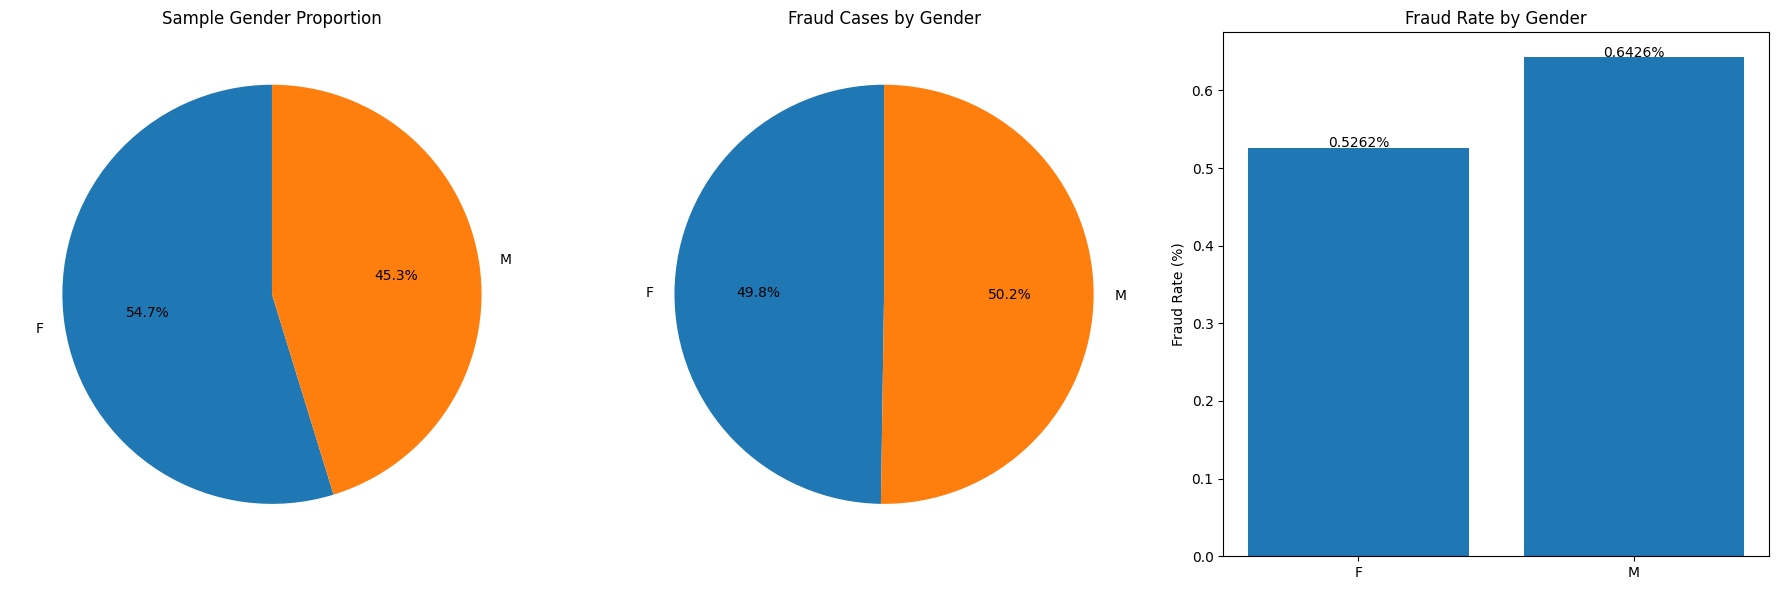

In [51]:
# Sample distribution
pop_share = fraud_rate_gender.set_index("gender")["count"]

# Fraud case by Gender
fraud_cases = fraud_rate_gender.set_index("gender")["sum"]

# Fraud rate by Gender
fraud_rate = fraud_rate_gender.set_index("gender")["fraud_rate"]

fig, axes = plt.subplots(1, 3, figsize=(18,6))

# Sample Gender Proportion
axes[0].pie(pop_share, labels=pop_share.index, autopct="%.1f%%", startangle=90)
axes[0].set_title("Sample Gender Proportion")

# Fraud cases by Gender
axes[1].pie(fraud_cases, labels=fraud_cases.index, autopct="%.1f%%", startangle=90)
axes[1].set_title("Fraud Cases by Gender")

# Fraud rate by Gender
axes[2].bar(fraud_rate.index, fraud_rate.values)
axes[2].set_title("Fraud Rate by Gender")
axes[2].set_ylabel("Fraud Rate (%)")
for i, v in enumerate(fraud_rate.values):
    axes[2].text(i, v + 0.001, f"{v:.4f}%", ha="center")

plt.tight_layout()
plt.show()

### Amount vs fraud

In [52]:
# Median transaction amount
median_amt = df_viz["amt"].median()

# High amount + Fraud count
high_amt_fraud_counts = df_viz.loc[(df_viz["amt"] > median_amt) & (df_viz["is_fraud"] == 1)]
customer_counts = high_amt_fraud_counts.groupby("customer_name").size().reset_index(name="num_high_amt_fraud")

# Average number of high-amount frauds per customer
avg_high_amt_fraud_per_customer = customer_counts["num_high_amt_fraud"].mean()

# Total number of high-amount transactions
total_high_amt = df_viz["amt"].loc[df_viz["amt"] > median_amt].mean()

# Ratio
ratio = avg_high_amt_fraud_per_customer*100 / total_high_amt

print(f"Probability that a transaction with higher than median amount is fradulent: {ratio:.2f}%")

Probability that a transaction with higher than median amount is fradulent: 6.37%


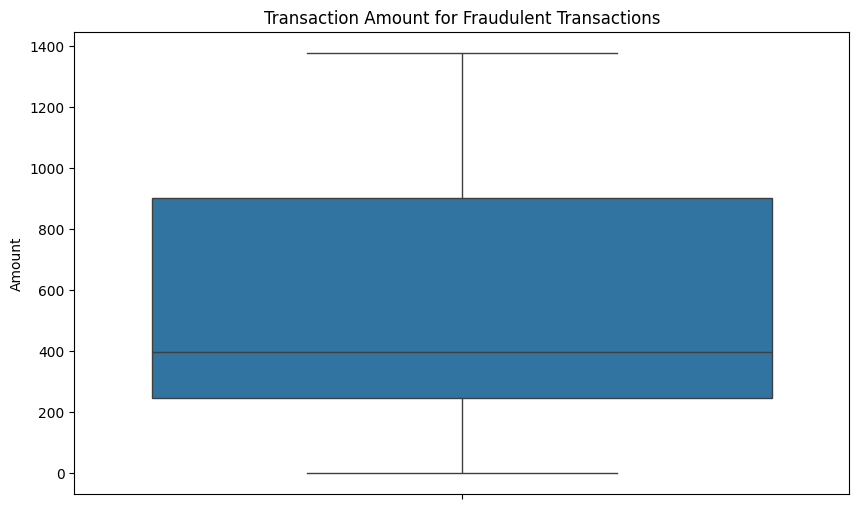

In [53]:
# Fradulent transactions' amount
fraud_df = df_viz[df_viz['is_fraud'] == 1]

plt.figure(figsize=(10, 6))
sns.boxplot(y=fraud_df['amt'])
plt.title('Transaction Amount for Fraudulent Transactions')
plt.ylabel('Amount')
plt.show()

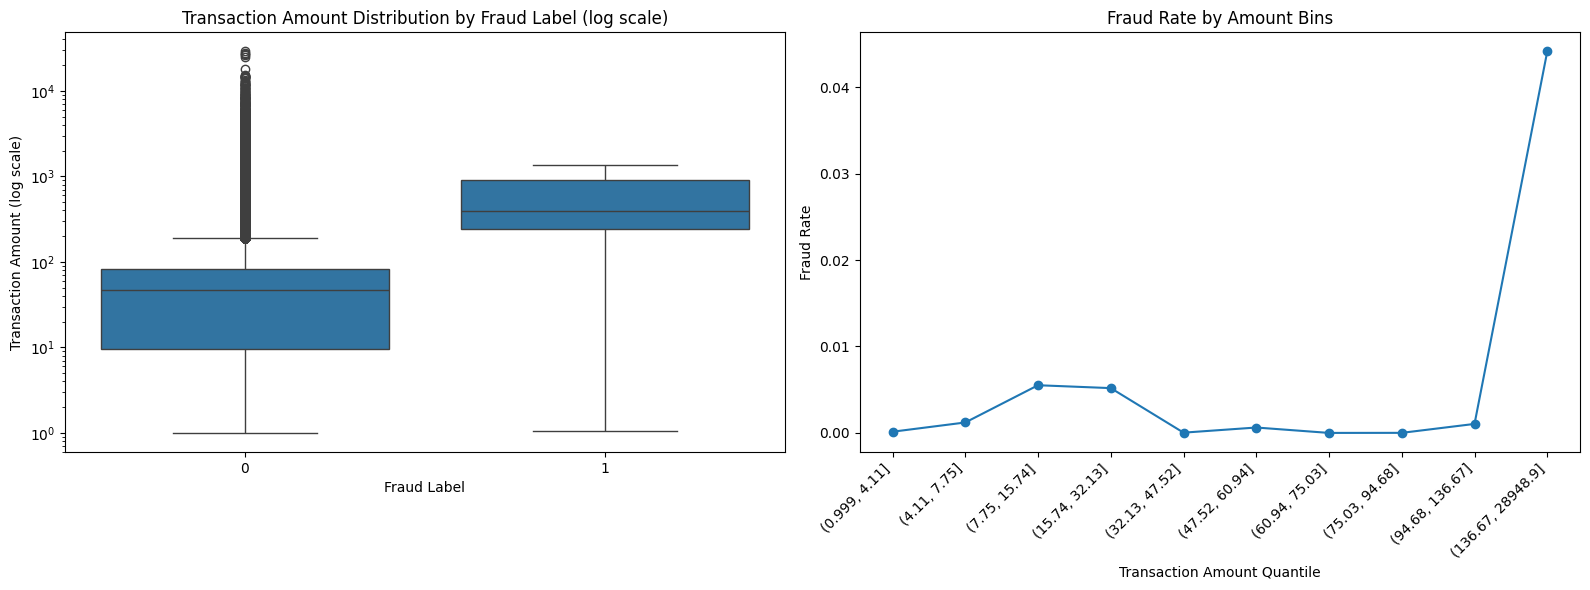

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Amount distribution by fraud label
sns.boxplot(x="is_fraud", y="amt", data=df_viz, ax=ax1)
ax1.set_yscale("log")
ax1.set_title("Transaction Amount Distribution by Fraud Label (log scale)")
ax1.set_xlabel("Fraud Label")
ax1.set_ylabel("Transaction Amount (log scale)")

# Fraud rate by amount quantiles
amount_bins = pd.qcut(df_viz["amt"], q=10)
fraud_rate = df_viz.groupby(amount_bins)["is_fraud"].mean()

fraud_rate.plot(kind="line", marker="o", ax=ax2)
ax2.set_title("Fraud Rate by Amount Bins")
ax2.set_ylabel("Fraud Rate")
ax2.set_xlabel("Transaction Amount Quantile")

ax2.set_xticks(range(len(fraud_rate.index)))
ax2.set_xticklabels([str(b) for b in fraud_rate.index], rotation=45, ha="right")

plt.tight_layout()
plt.show()

### Fraud by Generations


In [55]:
def categorize_generation(year):
    if 1924 <= year <= 1945:
        return "Silent"
    elif 1946 <= year <= 1964:
        return "Baby Boomer"
    elif 1965 <= year <= 1979:
        return "Gen X"
    elif 1980 <= year <= 1994:
        return "Millennials"
    else:
        return "Gen Z"

df_viz['generations'] = df_viz['dob_year'].apply(categorize_generation)

In [56]:
fraud_customers = (
    df_viz[df_viz["is_fraud"] == 1]
    .groupby("generations")["customer_name"]
    .nunique()
    .reset_index(name="n_customers_with_fraud")
)

total_customers = (
    df_viz.groupby("generations")["customer_name"]
    .nunique()
    .reset_index(name="n_customers")
)

fraud_by_generation = fraud_customers.merge(total_customers, on="generations")

count_fraud_generation = fraud_by_generation.copy()

fraud_by_generation["fraud_ratio"] = (
    fraud_by_generation["n_customers_with_fraud"]
    / fraud_by_generation["n_customers"]
)

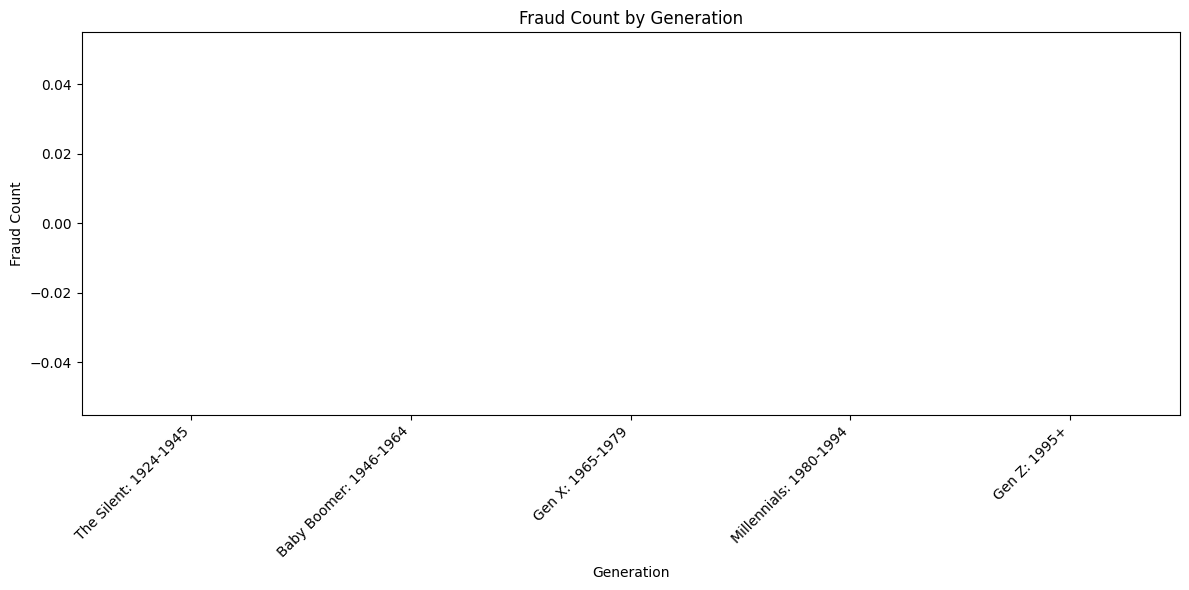

In [57]:
# Generation order for visualization
generation_order = [
    "The Silent: 1924-1945",
    "Baby Boomer: 1946-1964",
    "Gen X: 1965-1979",
    "Millennials: 1980-1994",
    "Gen Z: 1995+"
]

fraud_by_generation['generations'] = pd.Categorical(
    fraud_by_generation['generations'], categories=generation_order, ordered=True
)

# Sort
fraud_by_generation = fraud_by_generation.sort_values('generations')

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=fraud_by_generation,
    x='generations',
    y='n_customers_with_fraud'
     )

# Add count labels
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.0f}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center", va="bottom",
        fontsize=10, color="black"
    )

plt.title("Fraud Count by Generation")
plt.xlabel("Generation")
plt.ylabel("Fraud Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Step 3: Preprocessing

## 3.1. Train set preprocessing

### Time

In [58]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df["year"] = df["trans_date_trans_time"].dt.year
df["month"] = df["trans_date_trans_time"].dt.month
df["day"] = df["trans_date_trans_time"].dt.day
df["hour"] = df["trans_date_trans_time"].dt.hour
df["minute"] = df["trans_date_trans_time"].dt.minute
df["second"] = df["trans_date_trans_time"].dt.second

#### Day vs Night


In [59]:
# Group hour
def categorize_time_of_day(hour):
    if 18 <= hour or hour < 6:
        return 'Night'
    else:
        return 'Day'

df['time_of_day'] = df['hour'].apply(categorize_time_of_day)

#### Time Delta

In [60]:
df = df.sort_values(by=["cc_num", "trans_date_trans_time"])

# Calculate time difference between 2 transactions using the same credit card
df["prev_txn_date"] = df.groupby("cc_num")["trans_date_trans_time"].shift(1)
df["time_delta"] = (df["trans_date_trans_time"] - df["prev_txn_date"]).dt.total_seconds() / 3600

#### Split DoB

In [61]:
df["dob"] = pd.to_datetime(df["dob"])
df["dob_year"] = df["dob"].dt.year
df["dob_month"] = df["dob"].dt.month
df["dob_day"] = df["dob"].dt.day

#### Calculating age

In [62]:
df["age"] = df["year"] - df["dob_year"]

#### Rewrite unix_time

In [63]:
# As the original unix_time is not appropriate, decoding unix_time gives another date different from the trans_date, I will drop it
df = df.drop("unix_time", axis=1)

In [64]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])

# Create a new column with unix_time (seconds since epoch)
df["unix_time"] = df["trans_date_trans_time"].astype(int) // 10**9

### Split street components

In [65]:
splits = df["street"].str.split(" ", expand=True)

# Assign to new columns sequentially
df["str_number"]    = splits[0]
df["str_name"]      = splits[1]
df["str_type"]      = splits[2]
df["building_type"] = splits[3]
df["room_number"]   = splits[4]

df = df.drop('street', axis=1)

In [66]:
df["building_type"] = df["building_type"].replace({None: "House"})

### Split zip prefix

In [67]:
df["zip"] = df["zip"].astype(str).str.zfill(5)

# Extract first 3 digits (ZIP prefix / metro area)
df["zip_prefix"] = df["zip"].str[:3]

In [68]:
df = df.drop("zip", axis=1)

### Calculate distance (km) between merchants and customers

In [69]:
df['distance_km'] = haversine_vectorized(
    df['lat'], df['long'], df['merch_lat'], df['merch_long']
)

df = df.drop(["lat", "long", "merch_lat", "merch_long"], axis=1)

### Classify Generations based on Birth Year

In [70]:
df['generations'] = df['dob_year'].apply(categorize_generation)

### Specifically preprocess train set

#### Prepare train set for Light GBM

In [71]:
# Create a copy for Light GBM specialized preprocessing
df_lgbm = df.copy()

In [72]:
df_lgbm["zip_prefix"] = df_lgbm["zip_prefix"].astype(int)

In [73]:
df_lgbm["customer_name"] = df_lgbm["first"].str.cat(df_lgbm["last"], sep=' ')

In [74]:
df_lgbm["n_cc"] = df_lgbm.groupby("customer_name")["cc_num"].transform("nunique")

In [75]:
num_cols = df_lgbm.select_dtypes(include=['int64', 'float64']).columns

# Compute skewness
skewness = df_lgbm[num_cols].apply(lambda x: skew(x.dropna()))
skewness = skewness.sort_values(ascending=False)

print(skewness)

amt            42.277825
is_fraud       13.029107
n_cc            7.858677
city_pop        5.593847
time_delta      4.278013
cc_num          2.851876
zip_prefix      0.079813
unix_time       0.010313
distance_km    -0.236207
dtype: float64


In [76]:
# Log-scaled amount
df_lgbm["amt"] = np.log1p(df_lgbm["amt"])

In [77]:
# Flag transaction from 22 p.m. to 3 a.m.
df_lgbm["fraud_doubt_1"] = df_lgbm["hour"].apply(
    lambda h: 1 if (h >= 22 or h <= 3) else 0
)

In [78]:
# Flag short (than average) purchasing frequency
class FraudDoubt2:
    def __init__(self):
        self.avg_time_per_category = None

    def fit(self, df_lgbm):
        self.avg_time_per_category = (
            df_lgbm.groupby("category")["time_delta"].mean()
        ).to_dict()
        return self

    def transform(self, df_lgbm):
        df_lgbm["avg_time_cat"] = df_lgbm["category"].map(self.avg_time_per_category)
        df_lgbm["fraud_doubt_2"] = (df_lgbm["time_delta"] < df_lgbm["avg_time_cat"]).astype(int)
        return df_lgbm

In [79]:
flag2 = FraudDoubt2().fit(df_lgbm)
df_lgbm = flag2.transform(df_lgbm)

In [81]:
# Flag addreess shift
class FraudDoubt3:
    def __init__(self):
        self.mode_strname_per_category = None

    def fit(self, df_lgbm):
        self.mode_strname_per_category = (
            df_lgbm.groupby("category")["str_name"].agg(lambda x: x.mode()[0])
        ).to_dict()
        return self

    def transform(self, df_lgbm):
        df_lgbm["mode_strname_cat"] = df_lgbm["category"].map(self.mode_strname_per_category)
        df_lgbm["fraud_doubt_3"] = (df_lgbm["str_name"] != df_lgbm["mode_strname_cat"]).astype(int)
        return df_lgbm

In [82]:
flag3 = FraudDoubt3().fit(df_lgbm)
df_lgbm = flag3.transform(df_lgbm)

In [84]:
# Group state
east_states = {
    "ME","NH","VT","MA","RI","CT","NY","NJ","PA","DE","MD","VA","NC","SC",
    "GA","FL","WV","OH","IN","MI","KY","TN","AL","MS"
}

west_states = {
    "WA","OR","CA","NV","ID","MT","WY","UT","CO","AZ","NM","AK","HI"
}

df_lgbm["state"] = df_lgbm["state"].apply(
    lambda x: "East" if x in east_states else ("West" if x in west_states else "Central")
)

In [85]:
df_lgbm = df_lgbm.drop(["trans_date_trans_time", "merchant", "first", "last", "city", "dob", "trans_num", "customer_name", "prev_txn_date", "time_of_day"], axis=1)

In [86]:
df_lgbm = df_lgbm.drop(["mode_strname_cat", "str_name", "str_type", "job"], axis=1)

In [87]:
df_lgbm["room_number"] = df_lgbm["room_number"].fillna(0)
df_lgbm["room_number"] = df_lgbm["room_number"].astype(int)
df_lgbm["str_number"] = df_lgbm["str_number"].astype(int)

In [88]:
df_lgbm["time_delta"] = df_lgbm["time_delta"].fillna(0)

In [89]:
df_lgbm = df_lgbm.dropna()

In [90]:
# Define the desired column order
ordered_cols = [
    "cc_num", "category", "amt", "gender", "state", "city_pop",
    "unix_time", "year", "month", "day", "hour", "minute", "second",
    "dob_year", "dob_month", "dob_day", "time_delta", "generations", "age",
    "str_number", "building_type", "room_number", "zip_prefix", "n_cc",
    "distance_km", "fraud_doubt_1", "avg_time_cat", "fraud_doubt_2",
    "fraud_doubt_3", "is_fraud"
]

# Reorder columns
df_lgbm = df_lgbm[ordered_cols]

In [91]:
df_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 1017 to 1296427
Data columns (total 30 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   cc_num         1296675 non-null  int64  
 1   category       1296675 non-null  object 
 2   amt            1296675 non-null  float64
 3   gender         1296675 non-null  object 
 4   state          1296675 non-null  object 
 5   city_pop       1296675 non-null  int64  
 6   unix_time      1296675 non-null  int64  
 7   year           1296675 non-null  int32  
 8   month          1296675 non-null  int32  
 9   day            1296675 non-null  int32  
 10  hour           1296675 non-null  int32  
 11  minute         1296675 non-null  int32  
 12  second         1296675 non-null  int32  
 13  dob_year       1296675 non-null  int32  
 14  dob_month      1296675 non-null  int32  
 15  dob_day        1296675 non-null  int32  
 16  time_delta     1296675 non-null  float64
 17  generation

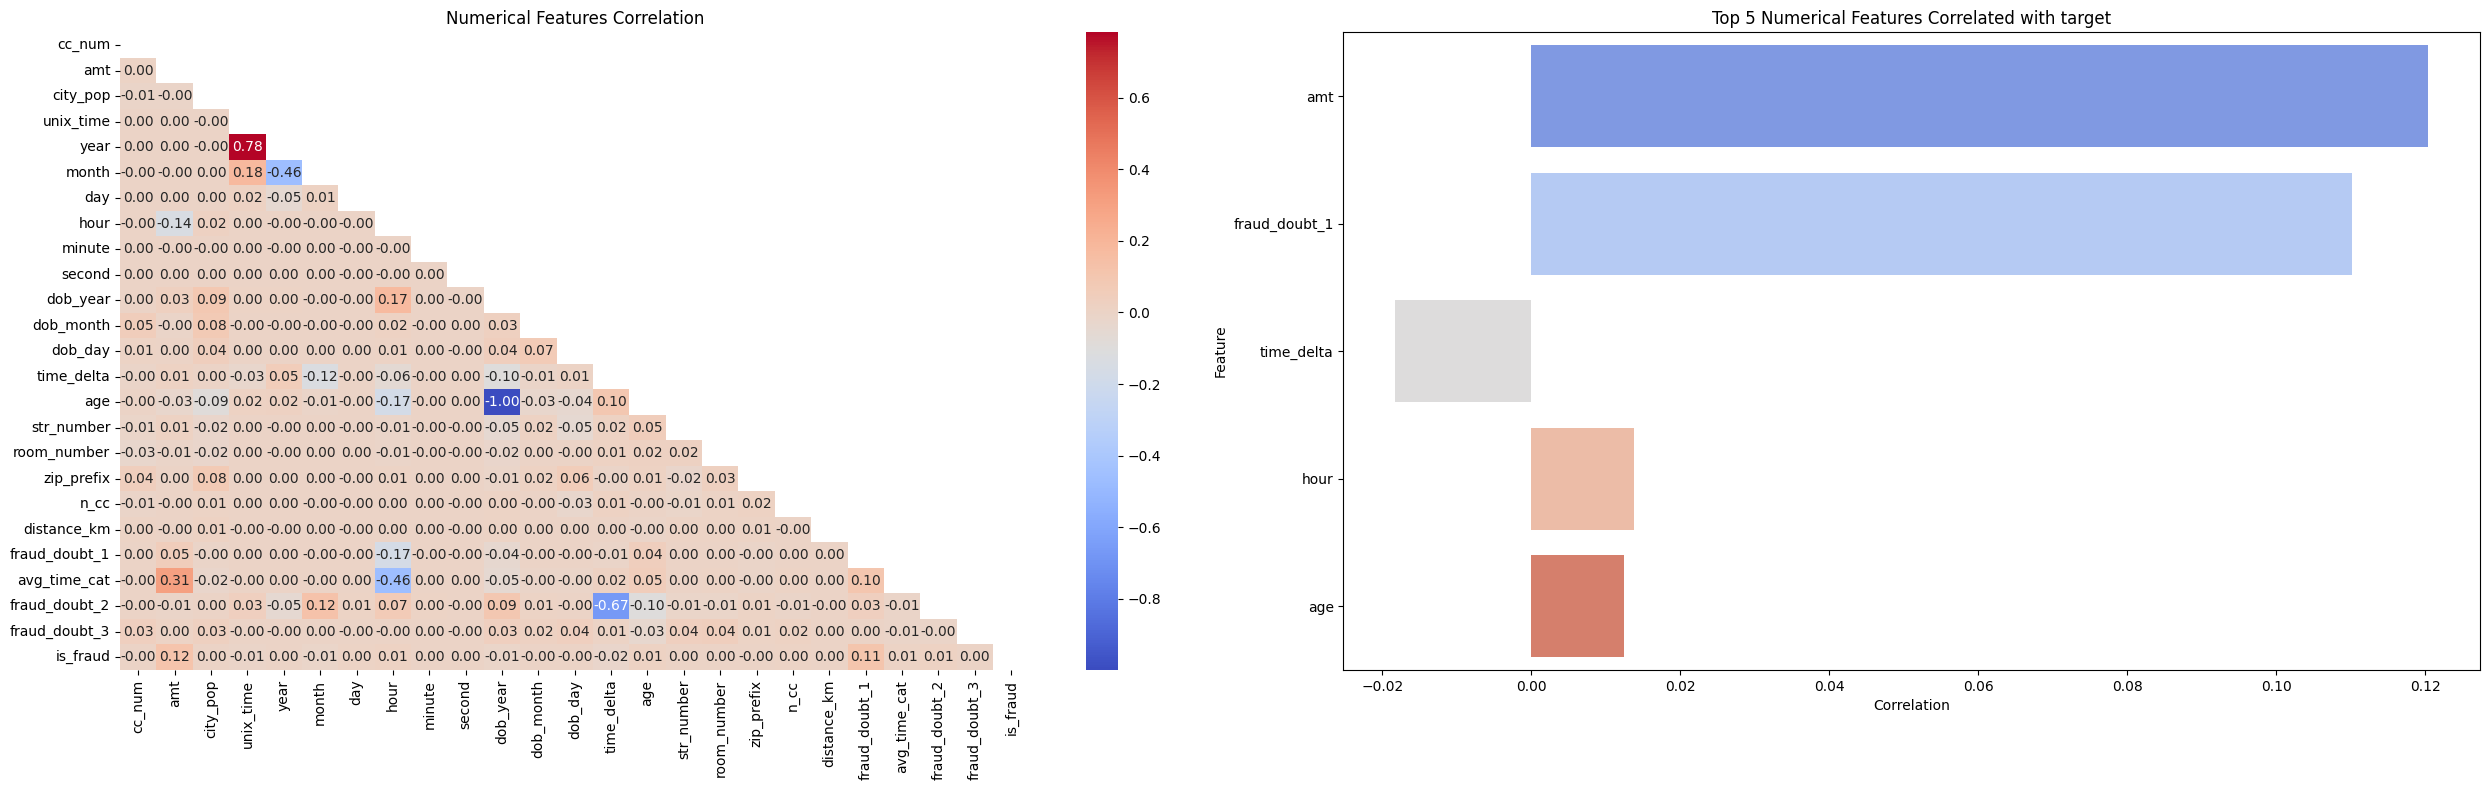

In [92]:
num_corr(df_lgbm)

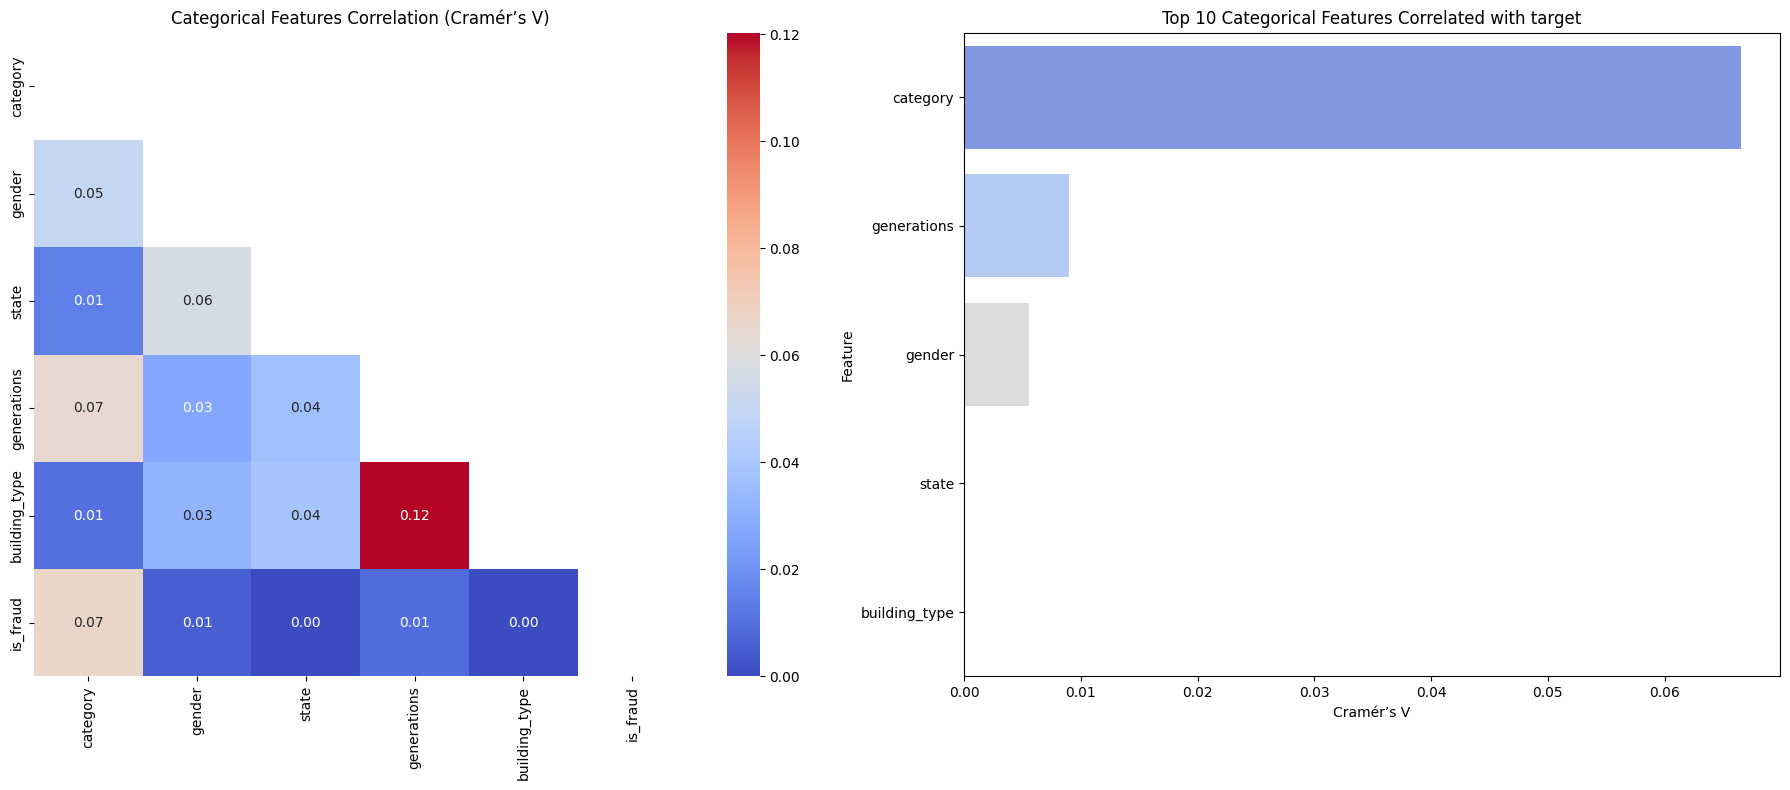

In [93]:
cat_corr(df_lgbm)

In [94]:
df_lgbm = df_lgbm.drop(columns=["year", "dob_year", "fraud_doubt_2", "avg_time_cat"], axis=1)

In [95]:
# Change dtype to category
categorical_cols = df_lgbm.select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_cols:
    df_lgbm[col] = df_lgbm[col].astype("category")

In [96]:
# Save train dtypes
dtype_map = df_lgbm.dtypes.apply(lambda x: x.name).to_dict()

joblib.dump(dtype_map, "train_dtypes.pkl")

['train_dtypes.pkl']

In [97]:
# Split X and y
X = df_lgbm.drop(columns=["is_fraud"])
y = df_lgbm["is_fraud"]

# Split dataset
X_train_lgbm, X_val_lgbm, y_train_lgbm, y_val_lgbm = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### Prepare train set for LogisiticReg, RF and XGBoost

In [148]:
df_train = df.drop(columns=["first", "last","str_number","room_number","cc_num","trans_date_trans_time", "prev_txn_date","unix_time", "dob","trans_num","city","building_type"],axis=1)

In [149]:
df_train["amt"] = np.log1p(df_train["amt"])

In [150]:
df_train.select_dtypes(include=['object', 'category']).nunique()

,0
merchant,693
category,14
gender,2
state,51
job,494
time_of_day,2
str_name,552
str_type,193
zip_prefix,526
generations,5


In [151]:
df_train=df_train.dropna()

#### Encode train set for LogisticReg, RF and XGBoost

In [152]:
train_encoded = df_train.copy()

# Frequency encoding features with many unique values
freq_cols = ["merchant", "state", "str_name", "str_type","job","zip_prefix"]
for col in freq_cols:
    freq_map = train_encoded[col].value_counts(normalize=True)
    train_encoded[col + "_freq"] = train_encoded[col].map(freq_map)

# One hot encoding features with few unique values
onehot_cols = ["category", "gender", "time_of_day"]
train_encoded = pd.get_dummies(train_encoded, columns=onehot_cols, drop_first=True)

## Target encoding
# target_cols = ["job", "zip_prefix"]
# te = TargetEncoder(cols=target_cols)
# train2_encoded[target_cols] = te.fit_transform(train2_encoded[target_cols], train2_encoded["is_fraud"])

# Label encoding
label_col = "generations"
le = LabelEncoder()
train_encoded[label_col] = le.fit_transform(train_encoded[label_col])


train_encoded = train_encoded.drop(columns=freq_cols  + [label_col])
df_train_encoded = train_encoded.copy()

In [153]:
df_train_encoded = reorder(df_train_encoded)

##  3.2. Test set preprocessing

In [98]:
df_test["trans_date_trans_time"] = pd.to_datetime(df_test["trans_date_trans_time"])
df_test["year"] = df_test["trans_date_trans_time"].dt.year
df_test["month"] = df_test["trans_date_trans_time"].dt.month
df_test["day"] = df_test["trans_date_trans_time"].dt.day
df_test["hour"] = df_test["trans_date_trans_time"].dt.hour
df_test["minute"] = df_test["trans_date_trans_time"].dt.minute
df_test["second"] = df_test["trans_date_trans_time"].dt.second

In [100]:
df_test = df_test.sort_values(by=["cc_num", "trans_date_trans_time"])

df_test["prev_txn_date"] = df_test.groupby("cc_num")["trans_date_trans_time"].shift(1)
df_test["time_delta"] = (df_test["trans_date_trans_time"] - df_test["prev_txn_date"]).dt.total_seconds() / 3600

In [101]:
df_test["dob"] = pd.to_datetime(df_test["dob"])
df_test["dob_year"] = df_test["dob"].dt.year
df_test["dob_month"] = df_test["dob"].dt.month
df_test["dob_day"] = df_test["dob"].dt.day

In [102]:
df_test["age"] = df_test["year"] - df_test["dob_year"]

In [103]:
df_test = df_test.drop("unix_time", axis=1).assign(
    trans_date_trans_time=lambda x: pd.to_datetime(x["trans_date_trans_time"]),
    unix_time=lambda x: x["trans_date_trans_time"].view("int64") // 10**9
)

In [104]:
splits_test = df_test["street"].str.split(" ", expand=True)

df_test["str_number"]    = splits[0]
df_test["str_name"]      = splits[1]
df_test["str_type"]      = splits[2]
df_test["building_type"] = splits[3]
df_test["room_number"]   = splits[4]

df_test = df_test.drop('street', axis=1)

In [105]:
df_test["building_type"] = df_test["building_type"].replace({None: "House"})

In [106]:
df_test["zip"] = df_test["zip"].astype(str).str.zfill(5)

df_test["zip_prefix"] = df_test["zip"].str[:3]
df_test = df_test.drop("zip", axis=1)

In [107]:
df_test['distance_km'] = haversine_vectorized(
    df_test['lat'], df_test['long'], df_test['merch_lat'], df_test['merch_long']
)

df_test = df_test.drop(["lat", "long", "merch_lat", "merch_long"], axis=1)

In [108]:
df_test['generations'] = df_test['dob_year'].apply(categorize_generation)

### Specifically preprocess test set

#### Prepare test set for Light GBM

In [109]:
df_test_lgbm = df_test.copy()

In [110]:
df_test_lgbm["zip_prefix"] = df_test_lgbm["zip_prefix"].astype(int)

In [111]:
df_test_lgbm["customer_name"] = df_test_lgbm["first"].str.cat(df_test_lgbm["last"], sep=' ')

In [112]:
df_test_lgbm["n_cc"] = df_test_lgbm.groupby("customer_name")["cc_num"].transform("nunique")

In [113]:
num_cols = df_test_lgbm.select_dtypes(include=['int64', 'float64']).columns

skewness = df_test_lgbm[num_cols].apply(lambda x: skew(x.dropna()))
skewness = skewness.sort_values(ascending=False)

print(skewness)

amt            37.133977
is_fraud       16.002510
n_cc            8.206144
city_pop        5.583400
time_delta      4.187849
cc_num          2.849196
zip_prefix      0.077376
unix_time      -0.077405
distance_km    -0.234440
dtype: float64


In [114]:
df_test_lgbm["amt"] = np.log1p(df_test_lgbm["amt"])

In [115]:
df_test_lgbm["fraud_doubt_1"] = df_test_lgbm["hour"].apply(
    lambda h: 1 if (h >= 22 or h <= 3) else 0
)

In [117]:
df_test_lgbm = flag3.transform(df_test_lgbm)

In [118]:
east_states = {
    "ME","NH","VT","MA","RI","CT","NY","NJ","PA","DE","MD","VA","NC","SC",
    "GA","FL","WV","OH","IN","MI","KY","TN","AL","MS"
}

west_states = {
    "WA","OR","CA","NV","ID","MT","WY","UT","CO","AZ","NM","AK","HI"
}

df_test_lgbm["state"] = df_test_lgbm["state"].apply(
    lambda x: "East" if x in east_states else ("West" if x in west_states else "Central")
)

In [119]:
df_test_lgbm = df_test_lgbm.drop(["trans_date_trans_time", "merchant", "first", "last", "city", "dob", "trans_num", "customer_name", "prev_txn_date", "time_of_day"], axis=1)

In [120]:
df_test_lgbm = df_test_lgbm.drop(["mode_strname_cat", "str_name", "str_type", "job"], axis=1)

In [121]:
df_test_lgbm["room_number"] = df_test_lgbm["room_number"].fillna(0)
df_test_lgbm["str_number"] = df_test_lgbm["str_number"].astype(int)
df_test_lgbm["room_number"]  = df_test_lgbm["room_number"] .astype(int)

In [122]:
df_test_lgbm["time_delta"] = df_test_lgbm["time_delta"].fillna(0)

In [123]:
df_test_lgbm = df_test_lgbm.dropna()

In [124]:
df_test_lgbm = df_test_lgbm[df_lgbm.columns]

In [125]:
df_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 1017 to 1296427
Data columns (total 26 columns):
 #   Column         Non-Null Count    Dtype   
---  ------         --------------    -----   
 0   cc_num         1296675 non-null  int64   
 1   category       1296675 non-null  category
 2   amt            1296675 non-null  float64 
 3   gender         1296675 non-null  category
 4   state          1296675 non-null  category
 5   city_pop       1296675 non-null  int64   
 6   unix_time      1296675 non-null  int64   
 7   month          1296675 non-null  int32   
 8   day            1296675 non-null  int32   
 9   hour           1296675 non-null  int32   
 10  minute         1296675 non-null  int32   
 11  second         1296675 non-null  int32   
 12  dob_month      1296675 non-null  int32   
 13  dob_day        1296675 non-null  int32   
 14  time_delta     1296675 non-null  float64 
 15  generations    1296675 non-null  category
 16  age            1296675 non-null  int32

In [126]:
df_test_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 157 to 553883
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   cc_num         555719 non-null  int64  
 1   category       555719 non-null  object 
 2   amt            555719 non-null  float64
 3   gender         555719 non-null  object 
 4   state          555719 non-null  object 
 5   city_pop       555719 non-null  int64  
 6   unix_time      555719 non-null  int64  
 7   month          555719 non-null  int32  
 8   day            555719 non-null  int32  
 9   hour           555719 non-null  int32  
 10  minute         555719 non-null  int32  
 11  second         555719 non-null  int32  
 12  dob_month      555719 non-null  int32  
 13  dob_day        555719 non-null  int32  
 14  time_delta     555719 non-null  float64
 15  generations    555719 non-null  object 
 16  age            555719 non-null  int32  
 17  str_number     555719 non-null  

In [127]:
dtype_map = joblib.load("train_dtypes.pkl")

def align_dtypes(df, dtype_map):
    for col, dtype in dtype_map.items():
        if col in df.columns:
            df[col] = df[col].astype(dtype)
    return df

df_test_lgbm = align_dtypes(df_test_lgbm, dtype_map)

In [128]:
X_test_lgbm = df_test_lgbm.drop(columns=["is_fraud"])
y_test_lgbm = df_test_lgbm["is_fraud"]

#### Prepare test set for LogisticReg, RF and XGBoost

In [157]:
df_test = df_test.drop(columns=["first","last","trans_num","str_number","room_number","city","cc_num","trans_date_trans_time", "prev_txn_date","unix_time", "dob","building_type"],axis=1)

In [158]:
df_test["amt"] = np.log1p(df_test["amt"])

In [159]:
df_test = df_test.dropna()

In [155]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1295692 entries, 2724 to 1296427
Data columns (total 25 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   merchant     1295692 non-null  object 
 1   category     1295692 non-null  object 
 2   amt          1295692 non-null  float64
 3   gender       1295692 non-null  object 
 4   state        1295692 non-null  object 
 5   city_pop     1295692 non-null  int64  
 6   job          1295692 non-null  object 
 7   is_fraud     1295692 non-null  int64  
 8   year         1295692 non-null  int32  
 9   month        1295692 non-null  int32  
 10  day          1295692 non-null  int32  
 11  hour         1295692 non-null  int32  
 12  minute       1295692 non-null  int32  
 13  second       1295692 non-null  int32  
 14  time_of_day  1295692 non-null  object 
 15  time_delta   1295692 non-null  float64
 16  dob_year     1295692 non-null  int32  
 17  dob_month    1295692 non-null  int32  
 18  dob_

In [160]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 554795 entries, 741 to 553883
Data columns (total 25 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   merchant     554795 non-null  object 
 1   category     554795 non-null  object 
 2   amt          554795 non-null  float64
 3   gender       554795 non-null  object 
 4   state        554795 non-null  object 
 5   city_pop     554795 non-null  int64  
 6   job          554795 non-null  object 
 7   is_fraud     554795 non-null  int64  
 8   year         554795 non-null  int32  
 9   month        554795 non-null  int32  
 10  day          554795 non-null  int32  
 11  hour         554795 non-null  int32  
 12  minute       554795 non-null  int32  
 13  second       554795 non-null  int32  
 14  time_of_day  554795 non-null  object 
 15  time_delta   554795 non-null  float64
 16  dob_year     554795 non-null  int32  
 17  dob_month    554795 non-null  int32  
 18  dob_day      554795 non-nul

In [161]:
# Match train columns
df_test = df_test[df_train.columns]

#### Encode test set for LogisticReg, RF and XGBoost

In [162]:
test_encoded = df_test.copy()

# Frequency Encoding
for col in freq_cols:
    freq_map = df_train[col].value_counts(normalize=True)
    test_encoded[col + "_freq"] = test_encoded[col].map(freq_map).fillna(0)

# One-Hot Encoding
test_encoded = pd.get_dummies(test_encoded, columns=onehot_cols, drop_first=True)

missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0

# Target Encoding
# test_encoded[target_cols] = te.transform(test_encoded[target_cols])

# Label Encoding
test_encoded[label_col] = test_encoded[label_col].map(
    lambda x: le.transform([x])[0] if x in le.classes_ else -1
)

# Drop categorical gốc
test_encoded = test_encoded.drop(columns=freq_cols + [label_col])

# Reorder
test_encoded = test_encoded[df_train_encoded.columns]

df_test_encoded = test_encoded.copy()

In [163]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1295692 entries, 2724 to 1296427
Data columns (total 36 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   amt                      1295692 non-null  float64
 1   city_pop                 1295692 non-null  int64  
 2   year                     1295692 non-null  int32  
 3   month                    1295692 non-null  int32  
 4   day                      1295692 non-null  int32  
 5   hour                     1295692 non-null  int32  
 6   minute                   1295692 non-null  int32  
 7   second                   1295692 non-null  int32  
 8   time_delta               1295692 non-null  float64
 9   dob_year                 1295692 non-null  int32  
 10  dob_month                1295692 non-null  int32  
 11  dob_day                  1295692 non-null  int32  
 12  age                      1295692 non-null  int32  
 13  distance_km              1295692 non-null  f

In [164]:
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 554795 entries, 741 to 553883
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   amt                      554795 non-null  float64
 1   city_pop                 554795 non-null  int64  
 2   year                     554795 non-null  int32  
 3   month                    554795 non-null  int32  
 4   day                      554795 non-null  int32  
 5   hour                     554795 non-null  int32  
 6   minute                   554795 non-null  int32  
 7   second                   554795 non-null  int32  
 8   time_delta               554795 non-null  float64
 9   dob_year                 554795 non-null  int32  
 10  dob_month                554795 non-null  int32  
 11  dob_day                  554795 non-null  int32  
 12  age                      554795 non-null  int32  
 13  distance_km              554795 non-null  float64
 14  merchan

In [166]:
# Split target
X = df_train_encoded.drop("is_fraud", axis=1)
y = df_train_encoded["is_fraud"]

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_test = df_test_encoded.drop("is_fraud", axis=1)
y_test = df_test_encoded["is_fraud"]

# Scale features for Logistic Regressionn
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## 3.3. Feature Importance


### Random Forest Feature Importance

In [ ]:
## Load model
# rf_classifier = joblib.load("rf_importance.pk1")

Top 15 Features quan trọng nhất theo Random Forest:
                 feature  importance
0                    amt    0.377019
5                   hour    0.076381
14         merchant_freq    0.047738
8             time_delta    0.047041
23  category_grocery_pos    0.041904
16         str_name_freq    0.041207
12                   age    0.032949
9               dob_year    0.030786
18              job_freq    0.028474
19       zip_prefix_freq    0.026515
13           distance_km    0.022977
1               city_pop    0.020653
6                 minute    0.018345
7                 second    0.018150
4                    day    0.017589


<Figure size 1200x800 with 0 Axes>

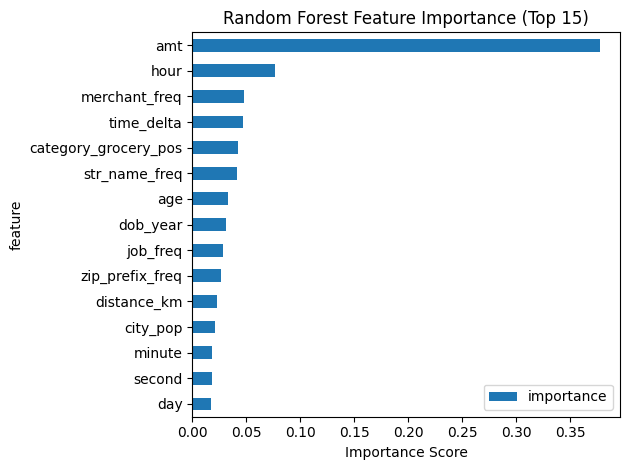


Random Forest Accuracy: 0.9984


In [ ]:
# Random Forest to measure Feature Importance
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Feature Importance ranking
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Important Features using Random Forest:\n")
print(rf_importance.head(15))

# Plot
plt.figure(figsize=(12, 8))
rf_importance.head(15).plot(x='feature', y='importance', kind='barh')
plt.title('Random Forest Feature Importance (Top 15)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Accuracy
rf_pred = rf_classifier.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"\nRandom Forest Accuracy: {rf_accuracy:.4f}")

In [ ]:
# Save model
joblib.dump(rf_classifier, "rf_importance.pk1")

['rf_importance.pk1']

### Logistic Regression Weights (Feature Coefficients)

In [ ]:
# lr_classifier = joblib.load("lr_importance.pk1")

Top 15 Features quan trọng nhất theo Logistic Regression (theo giá trị tuyệt đối):
                    feature  coefficient  abs_coefficient
0                       amt     1.767050         1.767050
34        time_of_day_Night     1.054366         1.054366
5                      hour     0.694267         0.694267
23     category_grocery_pos     0.587866         0.587866
21   category_gas_transport     0.519822         0.519822
8                time_delta    -0.422250         0.422250
27        category_misc_net     0.385919         0.385919
22     category_grocery_net     0.351436         0.351436
25            category_home    -0.323184         0.323184
30    category_shopping_net     0.305675         0.305675
3                     month    -0.258511         0.258511
19          zip_prefix_freq    -0.232990         0.232990
24  category_health_fitness    -0.228950         0.228950
26       category_kids_pets    -0.223141         0.223141
32          category_travel    -0.218271       

<Figure size 1200x800 with 0 Axes>

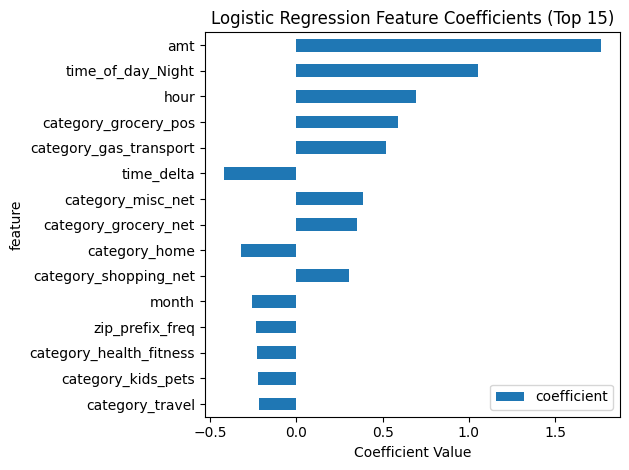


Logistic Regression Accuracy: 0.9965


In [ ]:
# Logistic Regression to measure Feature Importance
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
lr_classifier.fit(X_train_scaled, y_train)

# Feature Importance ranking
lr_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr_classifier.coef_[0],
    'abs_coefficient': np.abs(lr_classifier.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("Top 15 Features Important Features using Logistic Regression:\n")
print(lr_importance.head(15))

# Plot
plt.figure(figsize=(12, 8))
lr_importance.head(15).plot(x='feature', y='coefficient', kind='barh')
plt.title('Logistic Regression Feature Coefficients (Top 15)')
plt.xlabel('Coefficient Value')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Accuracy
lr_pred = lr_classifier.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"\nLogistic Regression Accuracy: {lr_accuracy:.4f}")

In [ ]:
joblib.dump(lr_classifier, "lr_importance.pk1")

['lr_importance.pk1']

# Step 4: Train model

## 4.1. Train and Evaluate Light GBM Model

### Train

#### Auto Weighting

In [ ]:
# lgbm = joblib.load("lgbm_auto.pk1")

In [129]:
# Build
lgbm = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    num_leaves=15,
    min_child_samples=50,
    lambda_l1=15.0,
    lambda_l2=15.0,
    class_weight="balanced",
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    verbose=-1
)

# Train
lgbm.fit(
    X_train_lgbm, y_train_lgbm,
    eval_set=[(X_val_lgbm, y_val_lgbm)],
    eval_metric='auc',
    categorical_feature=categorical_cols,
    callbacks=[early_stopping(stopping_rounds=50, verbose=False), log_evaluation(0)]
)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7, lambda_l1=15.0,
               lambda_l2=15.0, learning_rate=0.05, max_depth=4,
               min_child_samples=50, n_estimators=1000, num_leaves=15,
               random_state=42, subsample=0.7, verbose=-1)

In [140]:

joblib.dump(lgbm, "lgbm_auto.pk1")

['lgbm_auto.pk1']

#### Manual Weighting

In [ ]:
# lgbm_manual = joblib.load("lgbm_manual.pk1")

In [139]:
# Setup weights
n = 65
weights = np.where(y_train_lgbm == 1, n, 1)

# Build
lgbm_manual = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    num_leaves=15,
    min_child_samples=50,
    lambda_l1=15.0,
    lambda_l2=15.0,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    verbose=-1
)

# Train
lgbm_manual.fit(
    X_train_lgbm, y_train_lgbm,
    sample_weight=weights,
    eval_set=[(X_val_lgbm, y_val_lgbm)],
    eval_metric='auc',
    categorical_feature=categorical_cols,
    callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
)

LGBMClassifier(colsample_bytree=0.7, lambda_l1=15.0, lambda_l2=15.0,
               learning_rate=0.05, max_depth=4, min_child_samples=50,
               n_estimators=1000, num_leaves=15, random_state=42, subsample=0.7,
               verbose=-1)

In [141]:
joblib.dump(lgbm_manual, "lgbm_manual.pk1")

['lgbm_manual.pk1']

### Evaluate

In [137]:
def precision_recall(y_val_prob, y_prob, y_val, y_test):
    # Validation precision & recall
    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_prob)

    # Test precision & recall
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(recall_test, precision_test, color="blue", linewidth=2, label="Test Set")
    plt.plot(recall_val, precision_val, color="green", linewidth=2, linestyle="--", label="Validation Set")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve (Validation vs Test)")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(loc="lower left")
    plt.show()

#### Auto Weighting

In [130]:
# Predict on validation set
y_val_pred = lgbm.predict(X_val_lgbm, num_iteration=lgbm.best_iteration_)
y_val_proba = lgbm.predict_proba(X_val_lgbm, num_iteration=lgbm.best_iteration_)[:, 1]

print("\nClassification Report:\n", classification_report(y_val_lgbm, y_val_pred))
print("ROC AUC:", roc_auc_score(y_val_lgbm, y_val_proba))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    257834
           1       0.42      0.98      0.59      1501

    accuracy                           0.99    259335
   macro avg       0.71      0.98      0.79    259335
weighted avg       1.00      0.99      0.99    259335

ROC AUC: 0.999181628499984


In [131]:
# Predict on test set
y_pred_lgbm_auto = lgbm.predict(X_test_lgbm, num_iteration=lgbm.best_iteration_)
y_proba_lgbm_auto = lgbm.predict_proba(X_test_lgbm, num_iteration=lgbm.best_iteration_)[:, 1]

print("\nClassification Report:\n", classification_report(y_test_lgbm, y_pred_lgbm_auto))
print("ROC AUC:", roc_auc_score(y_test_lgbm, y_proba_lgbm_auto))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    553574
           1       0.36      0.94      0.52      2145

    accuracy                           0.99    555719
   macro avg       0.68      0.97      0.76    555719
weighted avg       1.00      0.99      0.99    555719

ROC AUC: 0.9978299791304015


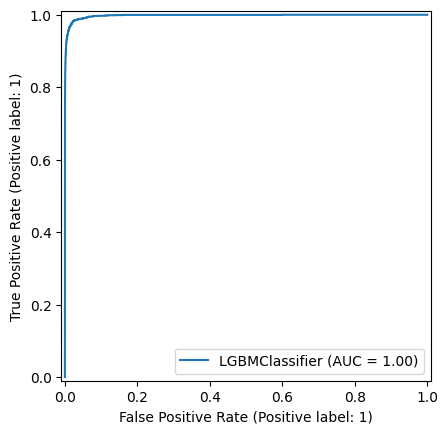

In [132]:
# ROC Curve
RocCurveDisplay.from_estimator(lgbm, X_test_lgbm, y_test_lgbm)
plt.show()

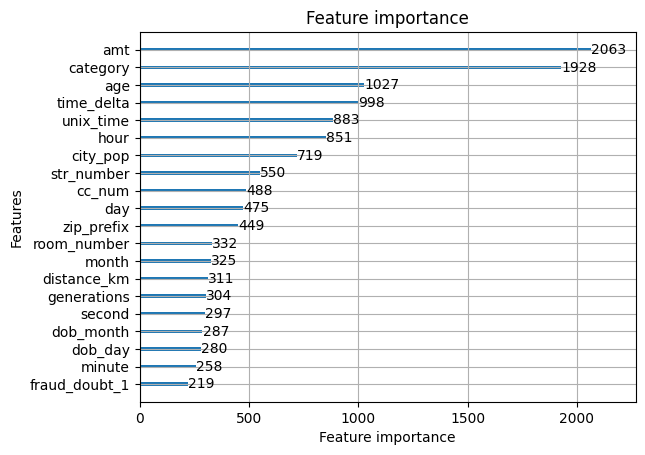

In [133]:
# Feature importance
lgb.plot_importance(lgbm, max_num_features=20)
plt.show()

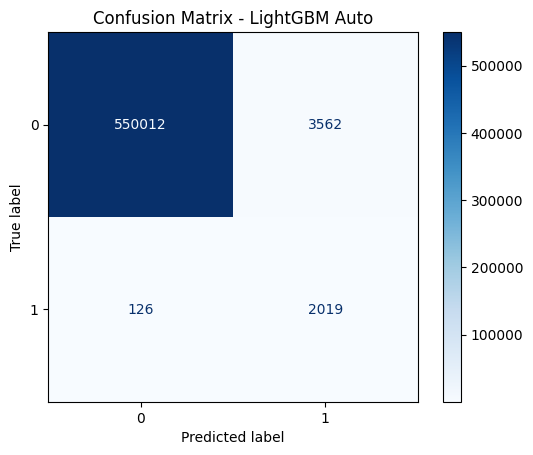

In [134]:
# Confusion Matrix
cm = confusion_matrix(y_test_lgbm, y_pred_lgbm_auto)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - LightGBM Auto")
plt.show()

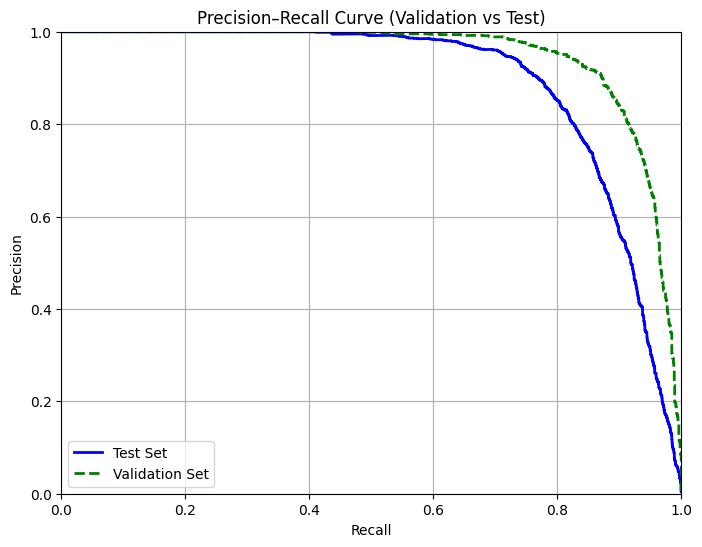

In [138]:
precision_recall(y_val_proba, y_proba_lgbm_auto, y_val_lgbm, y_test_lgbm)

#### Manual Weighting

In [142]:
# Predict on validation set
y_val_pred_manual = lgbm_manual.predict(X_val_lgbm, num_iteration=lgbm_manual.best_iteration_)
y_val_proba_manual = lgbm_manual.predict_proba(X_val_lgbm, num_iteration=lgbm_manual.best_iteration_)[:, 1]

print("\nClassification Report:\n", classification_report(y_val_lgbm, y_val_pred_manual))
print("ROC AUC:", roc_auc_score(y_val_lgbm, y_val_proba_manual))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.57      0.97      0.72      1501

    accuracy                           1.00    259335
   macro avg       0.78      0.98      0.86    259335
weighted avg       1.00      1.00      1.00    259335

ROC AUC: 0.999349999333607


In [143]:
# Predict on test set
y_pred_lgbm_manual = lgbm_manual.predict(X_test_lgbm, num_iteration=lgbm_manual.best_iteration_)
y_proba_lgbm_manual = lgbm_manual.predict_proba(X_test_lgbm, num_iteration=lgbm_manual.best_iteration_)[:, 1]

print("\nClassification Report:\n", classification_report(y_test_lgbm, y_pred_lgbm_manual))
print("ROC AUC:", roc_auc_score(y_test_lgbm, y_proba_lgbm_manual))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.50      0.92      0.65      2145

    accuracy                           1.00    555719
   macro avg       0.75      0.96      0.82    555719
weighted avg       1.00      1.00      1.00    555719

ROC AUC: 0.9979139926359268


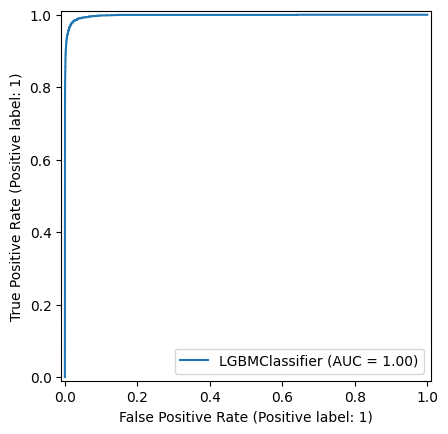

In [144]:
# ROC Curve
RocCurveDisplay.from_estimator(lgbm_manual, X_test_lgbm, y_test_lgbm)
plt.show()

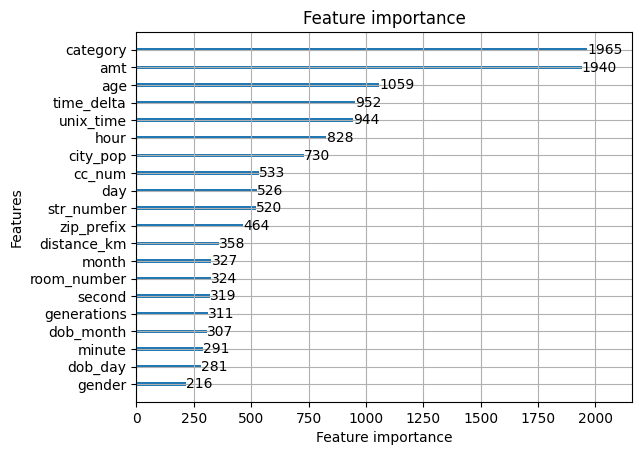

In [145]:
# Feature importance
lgb.plot_importance(lgbm_manual, max_num_features=20)
plt.show()

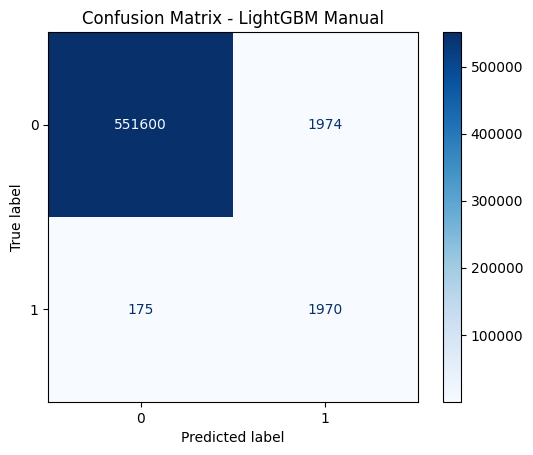

In [146]:
cm = confusion_matrix(y_test_lgbm, y_pred_lgbm_manual)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - LightGBM Manual")
plt.show()

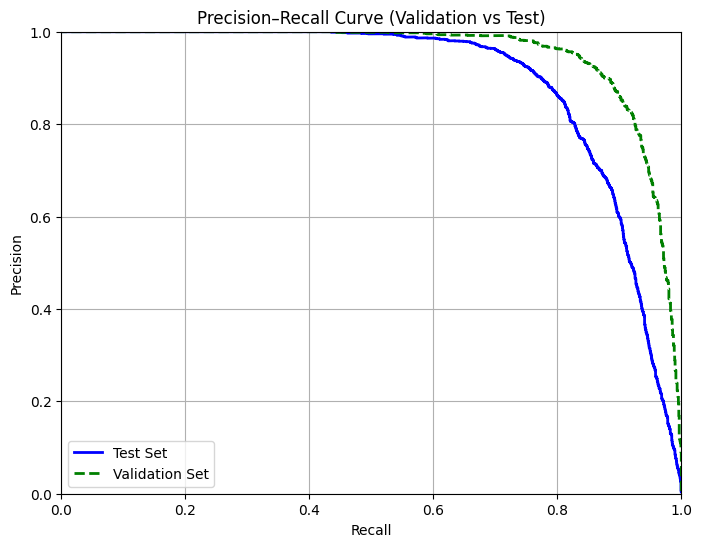

In [147]:
precision_recall(y_val_proba_manual, y_proba_lgbm_manual, y_val_lgbm, y_test_lgbm)

## 4.2. Train and Evaluate Models on Unsampled Data

### Train

In [ ]:
# lr = joblib.load("lr_samp.pk1")

In [ ]:
# Train Logistic Regression
lr = LogisticRegression(
    class_weight="balanced",
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)
lr.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
joblib.dump(lr, "lr.pk1")

['lr.pk1']

In [ ]:
# rf = joblib.load("rf_samp.pk1")

In [ ]:
# Train Random Forest
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
joblib.dump(rf, "rf.pk1")

['rf.pk1']

In [ ]:
# xgb = joblib.load("xgb.pk1")

In [167]:
# Calculate scale_pos_weight
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count

# Train XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight_value) # Added use_label_encoder and eval_metric and scale_pos_weight
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [172]:
joblib.dump(xgb, "xgb.pk1")

['xgb.pk1']

### Evaluate

#### Logistic Regression

In [ ]:
# Evaluate Logistic Regression on validation data
y_pred_val_lr = lr.predict(X_val_scaled)
y_prob_val_lr = lr.predict_proba(X_val_scaled)[:, 1]

print("Logistic Regression Classification Report (Training Data):")
print(classification_report(y_val, y_pred_val_lr, digits=4))
print("Logistic Regression ROC-AUC (Training Data):", roc_auc_score(y_val, y_prob_val_lr))
print("Logistic Regression PR-AUC (Training Data):", average_precision_score(y_val, y_prob_val_lr))

Logistic Regression Classification Report (Training Data):
              precision    recall  f1-score   support

         0.0     0.9983    0.8144    0.8970    247711
         1.0     0.0231    0.7646    0.0449      1423

    accuracy                         0.8141    249134
   macro avg     0.5107    0.7895    0.4710    249134
weighted avg     0.9928    0.8141    0.8922    249134

Logistic Regression ROC-AUC (Training Data): 0.8931498288136437
Logistic Regression PR-AUC (Training Data): 0.22256958519058723


In [ ]:
# Evaluate Logistic Regression on test data
y_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC:", average_precision_score(y_test, y_prob))

Classification report:
              precision    recall  f1-score   support

           0     0.9987    0.8704    0.9302    552670
           1     0.0206    0.7087    0.0400      2125

    accuracy                         0.8698    554795
   macro avg     0.5097    0.7896    0.4851    554795
weighted avg     0.9950    0.8698    0.9268    554795

ROC-AUC: 0.8944489976467183
PR-AUC: 0.1631589058515802


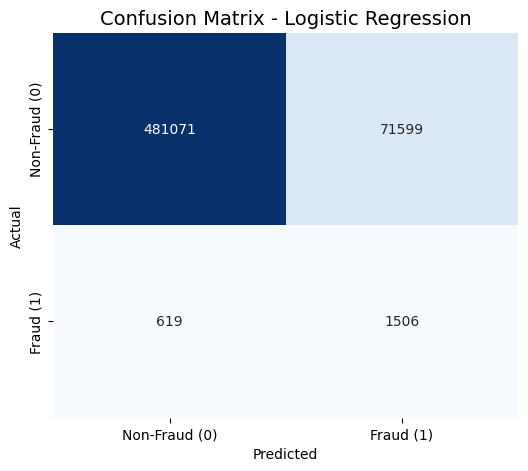

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Fraud (0)", "Fraud (1)"],
            yticklabels=["Non-Fraud (0)", "Fraud (1)"])
plt.title("Confusion Matrix - Logistic Regression", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Random Forest

In [ ]:
# Evaluate Random Forest on validation data
y_pred_val_rf = rf.predict(X_val_scaled)
y_prob_val_rf = rf.predict_proba(X_val_scaled)[:, 1]

print("RandomForest Classification Report (Training Data):")
print(classification_report(y_val, y_pred_val_rf, digits=4))
print("RandomForest ROC-AUC (Training Data):", roc_auc_score(y_val, y_prob_val_rf))
print("RandomForest PR-AUC (Training Data):", average_precision_score(y_val, y_prob_val_rf))

RandomForest Classification Report (Training Data):
              precision    recall  f1-score   support

         0.0     0.9982    1.0000    0.9991    247711
         1.0     0.9899    0.6859    0.8103      1423

    accuracy                         0.9982    249134
   macro avg     0.9940    0.8429    0.9047    249134
weighted avg     0.9982    0.9982    0.9980    249134

RandomForest ROC-AUC (Training Data): 0.9879494387789585
RandomForest PR-AUC (Training Data): 0.9069332509726554


In [ ]:
# Evaluate Random Forest on test data
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

print("RandomForest Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))
print("RandomForest ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("RandomForest PR-AUC:", average_precision_score(y_test, y_prob_rf))

RandomForest Classification Report:
              precision    recall  f1-score   support

           0     0.9986    1.0000    0.9993    552670
           1     0.9812    0.6386    0.7737      2125

    accuracy                         0.9986    554795
   macro avg     0.9899    0.8193    0.8865    554795
weighted avg     0.9985    0.9986    0.9984    554795

RandomForest ROC-AUC: 0.9793292314635156
RandomForest PR-AUC: 0.8590720592918495


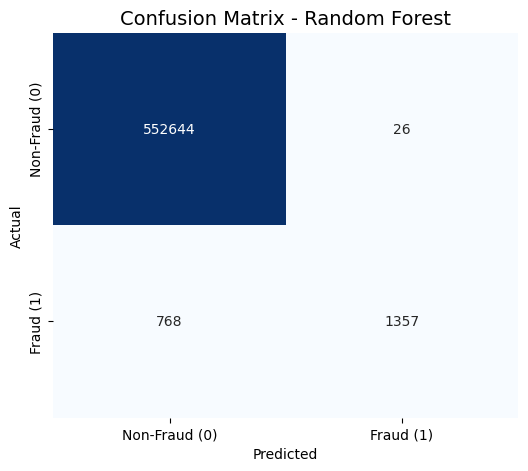

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Fraud (0)", "Fraud (1)"],
            yticklabels=["Non-Fraud (0)", "Fraud (1)"])
plt.title("Confusion Matrix - Random Forest", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

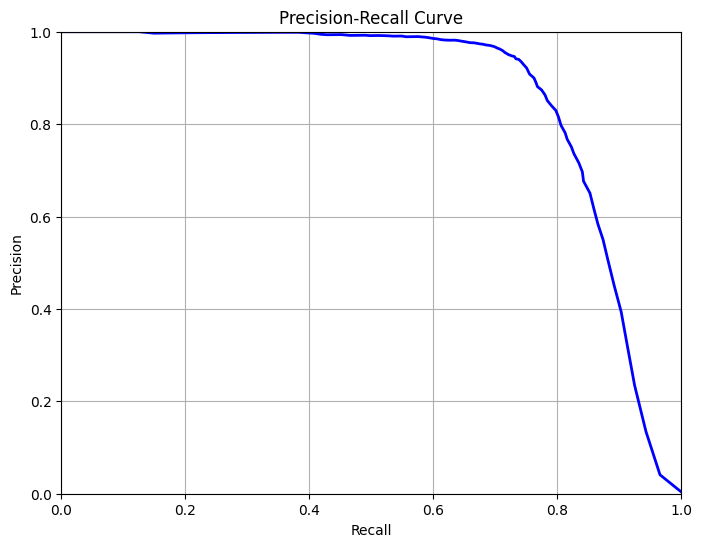

In [ ]:
# PR-AUC
precision_recall(y_prob_val_rf, y_prob_rf, y_val, y_test)

#### XGBoost

In [168]:
# Evaluate XGBoost on validation data
y_pred_val_xgb = xgb.predict(X_val_scaled)
y_prob_val_xgb = xgb.predict_proba(X_val_scaled)[:, 1]

print("XGBoost Classification Report (Training Data):")
print(classification_report(y_val, y_pred_val_xgb, digits=4))
print("XGBoost ROC-AUC (Training Data):", roc_auc_score(y_val, y_prob_val_xgb))
print("XGBoost PR-AUC (Training Data):", average_precision_score(y_val, y_prob_val_xgb))

XGBoost Classification Report (Training Data):
              precision    recall  f1-score   support

           0     0.9997    0.9969    0.9983    257653
           1     0.6418    0.9549    0.7676      1486

    accuracy                         0.9967    259139
   macro avg     0.8208    0.9759    0.8830    259139
weighted avg     0.9977    0.9967    0.9970    259139

XGBoost ROC-AUC (Training Data): 0.9989487279726785
XGBoost PR-AUC (Training Data): 0.9518928018282705


In [169]:
# Evaluate XGBoost on test data
y_pred_xgb = xgb.predict(X_test_scaled)
y_prob_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))
print("XGBoost PR-AUC:", average_precision_score(y_test, y_prob_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9972    0.9984    552670
           1     0.5511    0.9087    0.6861      2125

    accuracy                         0.9968    554795
   macro avg     0.7754    0.9529    0.8422    554795
weighted avg     0.9979    0.9968    0.9972    554795

XGBoost ROC-AUC: 0.997630557539389
XGBoost PR-AUC: 0.8974213335540431


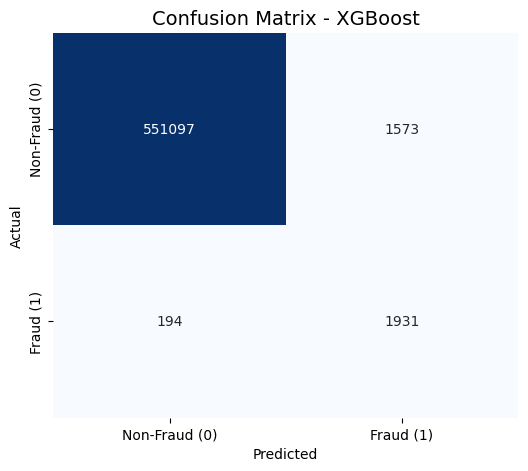

In [170]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Fraud (0)", "Fraud (1)"],
            yticklabels=["Non-Fraud (0)", "Fraud (1)"])
plt.title("Confusion Matrix - XGBoost", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

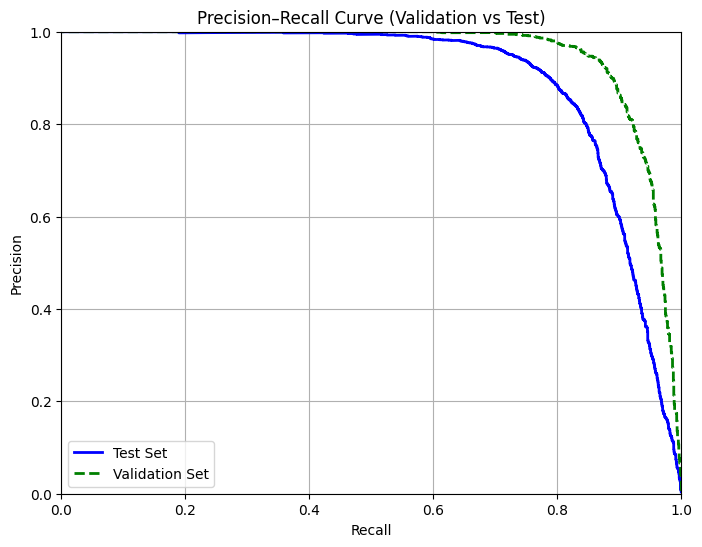

In [171]:
# PR-AUC
precision_recall(y_prob_val_xgb, y_prob_xgb, y_val, y_test)

## Data Sampling

In [173]:
# Downsampling to 600,000 records
rus = RandomUnderSampler(sampling_strategy={0: 600000, 1: len(y_train[y_train == 1])}, random_state=42)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_scaled, y_train)

print("Shape of X_train_scaled after undersampling:", X_train_undersampled.shape)
print("Shape of y_train_scaled after undersampling:", y_train_undersampled.shape)
print("\nDistribution of the target variable after undersampling:\n")
print(pd.Series(y_train_undersampled).value_counts())

Shape of X_train_scaled after undersampling: (605945, 35)
Shape of y_train_scaled after undersampling: (605945,)
Distribution of the target variable after undersampling:
is_fraud
0    600000
1      5945
Name: count, dtype: int64


In [174]:
# SMOTE fraud case
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_undersampled, y_train_undersampled)

print("Shape of X_train_scaled after SMOTE:", X_train_resampled.shape)
print("Shape of y_train_scaled after SMOTE:", y_train_resampled.shape)
print("\nDistribution of the target variable after SMOTE:\n")
print(pd.Series(y_train_resampled).value_counts())

Shape of X_train_scaled after SMOTE: (1200000, 35)
Shape of y_train_scaled after SMOTE: (1200000,)
Distribution of the target variable after SMOTE:
is_fraud
0    600000
1    600000
Name: count, dtype: int64


## 4.3. Train and Evaluate Models on Resampled Data

### Train

In [ ]:
# lr_resampled = joblib.load("lr_samp.pk1")

In [ ]:
# Train Logistic Regression on resampled data
lr_resampled = LogisticRegression(
    class_weight="balanced",
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)
lr_resampled.fit(X_train_resampled, y_train_resampled)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
joblib.dump(lr_resampled, "lr_samp.pk1")

['lr_samp.pk1']

In [ ]:
# rf_resampled = joblib.load("rf_samp.pk1")

In [ ]:
# Train Random Forest on resampled data
rf_resampled = RandomForestClassifier(max_depth=25, random_state=42)
rf_resampled.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=25, random_state=42)

In [ ]:
joblib.dump(rf_resampled, "rf_samp.pk1")

['rf_samp.pk1']

In [ ]:
# xgb_resampled = joblib.load("xgb_samp.pk1")

In [175]:
# Train XGBoost on resampled data
xgb_resampled = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_resampled.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [176]:
joblib.dump(xgb_resampled, "xgb_resamp.pk1")

['xgb_resamp.pk1']

### Evaluate

#### Logistic Regression

In [ ]:
# Evaluate Logistic Regression on validation data
y_pred_val_lr_resampled = lr_resampled.predict(X_val_scaled)
y_prob_val_lr_resampled = lr_resampled.predict_proba(X_val_scaled)[:, 1]

print("Logistic Regression Classification Report (Resampled Training Data):")
print(classification_report(y_val, y_pred_val_lr_resampled, digits=4))
print("Logistic Regression ROC-AUC (Resampled Training Data):", roc_auc_score(y_val, y_prob_val_lr_resampled))
print("Logistic Regression PR-AUC (Resampled Training Data):", average_precision_score(y_val, y_prob_val_lr_resampled))

Logistic Regression Classification Report (Resampled Training Data):
              precision    recall  f1-score   support

         0.0     0.9983    0.8192    0.8999    247711
         1.0     0.0235    0.7583    0.0456      1423

    accuracy                         0.8188    249134
   macro avg     0.5109    0.7887    0.4728    249134
weighted avg     0.9927    0.8188    0.8950    249134

Logistic Regression ROC-AUC (Resampled Training Data): 0.8941813790991613
Logistic Regression PR-AUC (Resampled Training Data): 0.21769135494000535


In [ ]:
# Evaluate Logistic Regression on test data
y_pred_lr_resampled = lr_resampled.predict(X_test_scaled)
y_prob_lr_resampled = lr_resampled.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Classification Report (Resampled Data):")
print(classification_report(y_test, y_pred_lr_resampled, digits=4))
print("Logistic Regression ROC-AUC (Resampled Data):", roc_auc_score(y_test, y_prob_lr_resampled))
print("Logistic Regression PR-AUC (Resampled Data):", average_precision_score(y_test, y_prob_lr_resampled))

Logistic Regression Classification Report (Resampled Data):
              precision    recall  f1-score   support

           0     0.9986    0.8908    0.9416    552670
           1     0.0235    0.6847    0.0455      2125

    accuracy                         0.8900    554795
   macro avg     0.5111    0.7877    0.4936    554795
weighted avg     0.9949    0.8900    0.9382    554795

Logistic Regression ROC-AUC (Resampled Data): 0.8940922618433083
Logistic Regression PR-AUC (Resampled Data): 0.1585938293753507


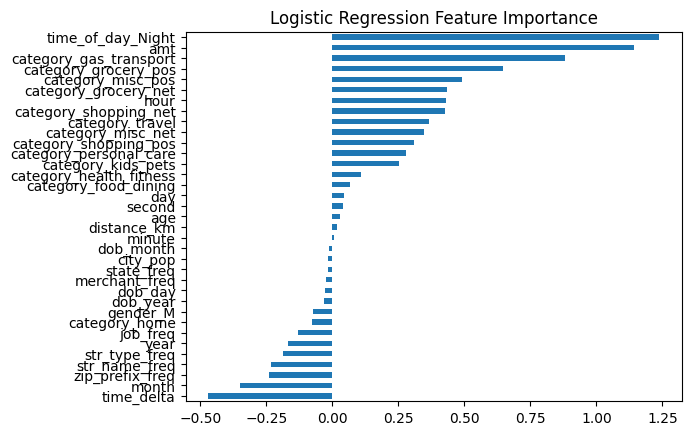

In [ ]:
# Feature Importance
feature_names = X.columns.tolist()

coefs = lr_resampled.coef_[0]   # logistic regression coefficients
importance = pd.Series(coefs, index=feature_names)

importance.sort_values().plot(kind="barh")
plt.title("Logistic Regression Feature Importance")
plt.show()

#### Random Forest

In [ ]:
# Evaluate Random Forest on validation data
y_pred_val_rf_resampled = rf_resampled.predict(X_val_scaled)
y_prob_val_rf_resampled = rf_resampled.predict_proba(X_val_scaled)[:, 1]

print("RandomForest Classification Report (Resampled Training Data):")
print(classification_report(y_val, y_pred_val_rf_resampled, digits=4))
print("RandomForest ROC-AUC (Resampled Training Data):", roc_auc_score(y_val, y_prob_val_rf_resampled))
print("RandomForest PR-AUC (Resampled Training Data):", average_precision_score(y_val, y_prob_val_rf_resampled))

RandomForest Classification Report (Resampled Training Data):
              precision    recall  f1-score   support

         0.0     0.9991    0.9987    0.9989    247711
         1.0     0.7885    0.8356    0.8113      1423

    accuracy                         0.9978    249134
   macro avg     0.8938    0.9171    0.9051    249134
weighted avg     0.9979    0.9978    0.9978    249134

RandomForest ROC-AUC (Resampled Training Data): 0.9943864718262732
RandomForest PR-AUC (Resampled Training Data): 0.8846839977551344


In [ ]:
# Evaluate Random Forest on test data
y_pred_rf_resampled = rf_resampled.predict(X_test_scaled)
y_prob_rf_resampled = rf_resampled.predict_proba(X_test_scaled)[:, 1]

print("RandomForest Classification Report (Resampled Data):")
print(classification_report(y_test, y_pred_rf_resampled, digits=4))
print("RandomForest ROC-AUC (Resampled Data):", roc_auc_score(y_test, y_prob_rf_resampled))
print("RandomForest PR-AUC (Resampled Data):", average_precision_score(y_test, y_prob_rf_resampled))

RandomForest Classification Report (Resampled Data):
              precision    recall  f1-score   support

           0     0.9993    0.9989    0.9991    552670
           1     0.7426    0.8132    0.7763      2125

    accuracy                         0.9982    554795
   macro avg     0.8709    0.9060    0.8877    554795
weighted avg     0.9983    0.9982    0.9982    554795

RandomForest ROC-AUC (Resampled Data): 0.9923628605092498
RandomForest PR-AUC (Resampled Data): 0.8456060608531103


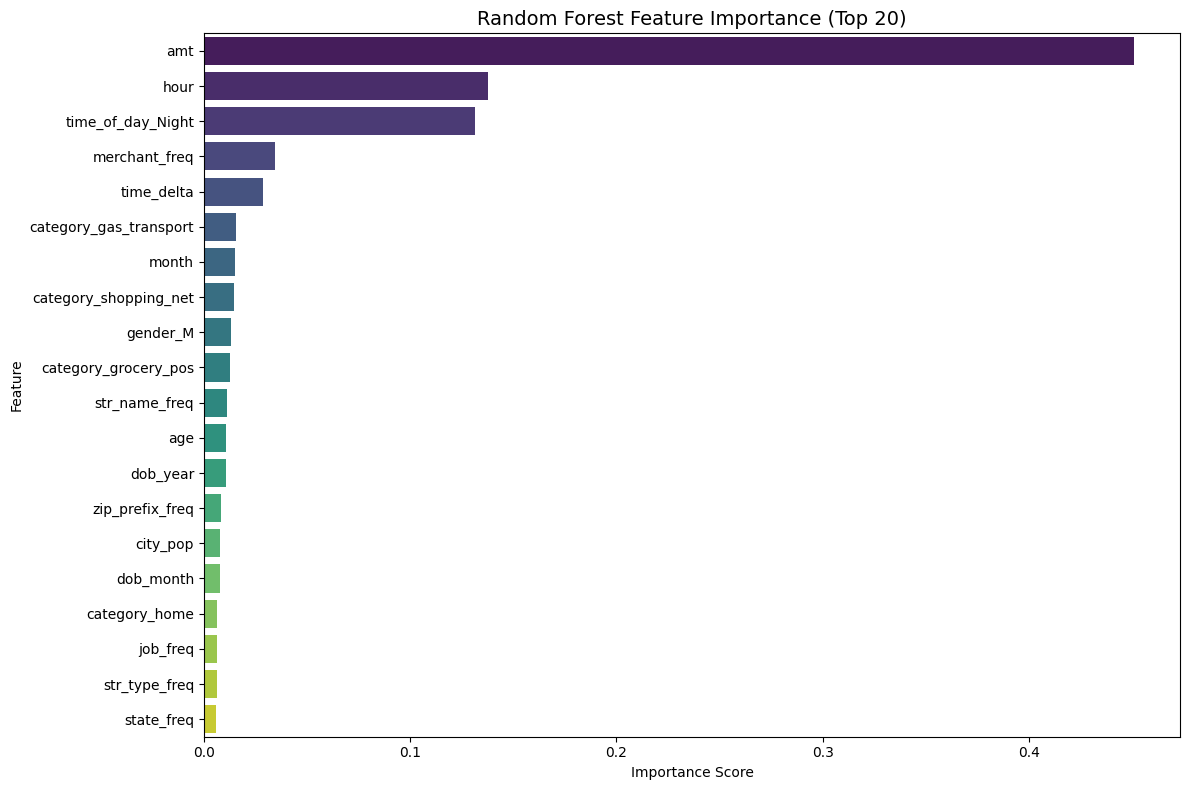

In [ ]:
# Feature Importance ranking
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_resampled.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20
plt.figure(figsize=(12, 8))
sns.barplot(
    data=rf_importance.head(20),
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title('Random Forest Feature Importance (Top 20)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

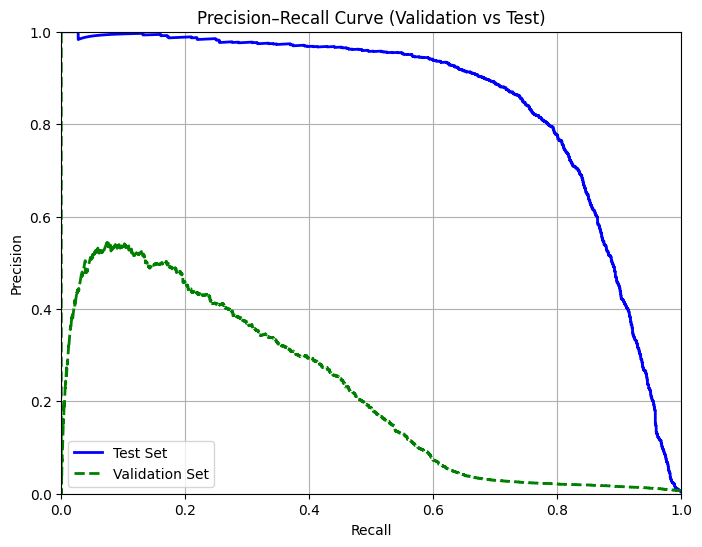

In [ ]:
precision_recall(y_prob_val_lr_resampled, y_prob_rf_resampled, y_val, y_test)

#### XGBoost

In [177]:
# Evaluate XGBoost on validation data
y_pred_val_xgb_resampled = xgb_resampled.predict(X_val_scaled)
y_prob_val_xgb_resampled = xgb_resampled.predict_proba(X_val_scaled)[:, 1]

print("XGBoost Classification Report (Resampled Training Data):")
print(classification_report(y_val, y_pred_val_xgb_resampled, digits=4))
print("XGBoost ROC-AUC (Resampled Training Data):", roc_auc_score(y_val, y_prob_val_xgb_resampled))
print("XGBoost PR-AUC (Resampled Training Data):", average_precision_score(y_val, y_prob_val_xgb_resampled))

XGBoost Classification Report (Resampled Training Data):
              precision    recall  f1-score   support

           0     0.9994    0.9990    0.9992    257653
           1     0.8377    0.8890    0.8626      1486

    accuracy                         0.9984    259139
   macro avg     0.9185    0.9440    0.9309    259139
weighted avg     0.9984    0.9984    0.9984    259139

XGBoost ROC-AUC (Resampled Training Data): 0.9984121784001967
XGBoost PR-AUC (Resampled Training Data): 0.9358030235925938


In [178]:
# Evaluate XGBoost on test data
y_pred_xgb_resampled = xgb_resampled.predict(X_test_scaled)
y_prob_xgb_resampled = xgb_resampled.predict_proba(X_test_scaled)[:, 1]

print("XGBoost Classification Report (Resampled Data):")
print(classification_report(y_test, y_pred_xgb_resampled, digits=4))
print("XGBoost ROC-AUC (Resampled Data):", roc_auc_score(y_test, y_prob_xgb_resampled))
print("XGBoost PR-AUC (Resampled Data):", average_precision_score(y_test, y_prob_xgb_resampled))

XGBoost Classification Report (Resampled Data):
              precision    recall  f1-score   support

           0     0.9993    0.9993    0.9993    552670
           1     0.8096    0.8184    0.8139      2125

    accuracy                         0.9986    554795
   macro avg     0.9044    0.9088    0.9066    554795
weighted avg     0.9986    0.9986    0.9986    554795

XGBoost ROC-AUC (Resampled Data): 0.9967753679197989
XGBoost PR-AUC (Resampled Data): 0.8818172166145307


<Figure size 1200x800 with 0 Axes>

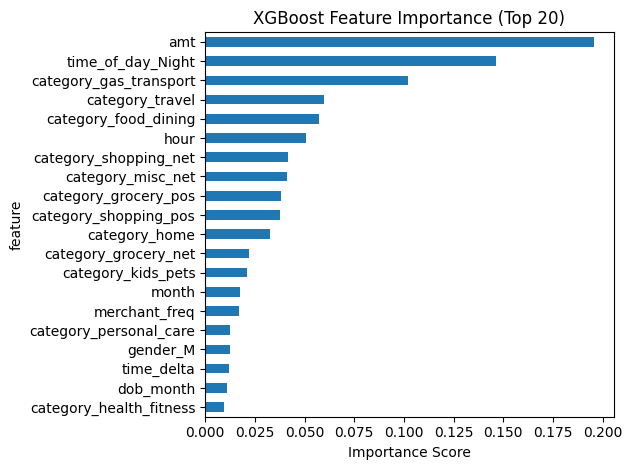

In [179]:
# Feature Importance ranking
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_resampled.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15
plt.figure(figsize=(12,8))
xgb_importance.head(20).plot(x='feature', y='importance', kind='barh', legend=False)
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

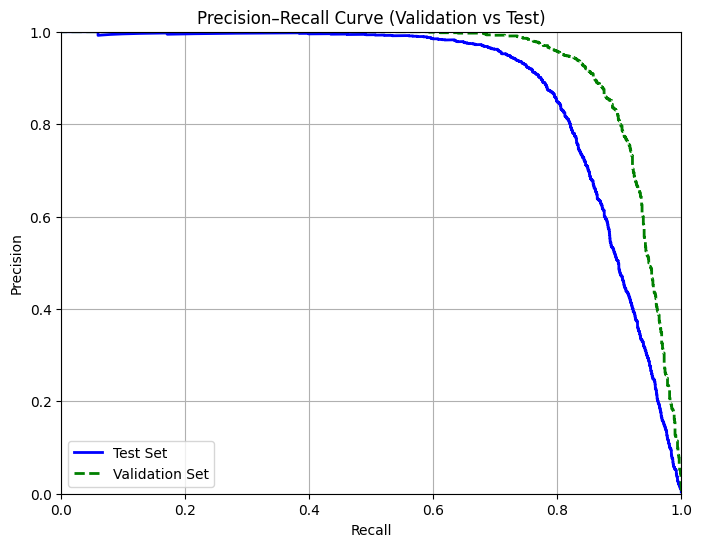

In [181]:
precision_recall(y_prob_val_xgb_resampled, y_prob_xgb_resampled, y_val, y_test)

# Step 5: Summary

## Light GBM

In [ ]:
def compare_model_results(y_test, predictions, probabilities=None, decimals=3):
    rows = []

    for name, y_pred in predictions.items():
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0, target_names=['0', '1'])

        metrics = {
            "precision_0": report["0"]["precision"],
            "recall_0": report["0"]["recall"],
            "precision_1": report["1"]["precision"],
            "recall_1": report["1"]["recall"],
        }

        if probabilities and name in probabilities:
            y_prob = probabilities[name]
            metrics["roc_auc"] = roc_auc_score(y_test, y_prob)
            metrics["pr_auc"] = average_precision_score(y_test, y_prob)

        rows.append((name, metrics))

    df = pd.DataFrame({name: m for name, m in rows}).T
    return df.round(decimals)

predictions_lgbm = {
    "LightGBM Auto": y_pred_lgbm_auto,
    "LightGBM Manual": y_pred_lgbm_manual
}
probabilities_lgbm = {
    "LightGBM Auto": y_proba_lgbm_auto,
    "LightGBM Manual": y_proba_lgbm_manual
}

results_lgbm_df = compare_model_results(y_test_lgbm, predictions_lgbm, probabilities_lgbm)
results_lgbm_df

,precision_0,recall_0,precision_1,recall_1,roc_auc,pr_auc
LightGBM Auto,1.0,0.994,0.370,0.939,0.998,0.888
LightGBM Manual,1.0,0.997,0.529,0.906,0.998,0.890


## Logistic Regression, Random Forest and XGBoost

In [ ]:
predictions = {
    "LogisticReg": y_pred_lr_resampled,
    "RandomForest": y_pred_rf_resampled,
    "XGBoost": y_pred_xgb_resampled
}
probabilities = {
    "LogisticReg": y_prob_lr_resampled,
    "RandomForest": y_prob_rf_resampled,
    "XGBoost": y_prob_xgb_resampled
}

results_df = compare_model_results(y_test, predictions, probabilities)
results_df

,precision_0,recall_0,precision_1,recall_1,roc_auc,pr_auc
LogisticReg,0.999,0.891,0.024,0.685,0.894,0.159
RandomForest,0.999,0.999,0.743,0.813,0.992,0.846
XGBoost,0.999,0.999,0.807,0.816,0.996,0.880
